In [147]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,5

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Based on the characterization of the Axon-Hillock design performed in AHOsc_Char.ipynb and AHOsc_Optimize.ipynb, we have one good solution for large currents and two possible solutions for small currents.  This notebook will be used to show the final results before we choose a final design to help us debug and optimize these circuits until we have a promising final solution.  Hopefully, once we've optimized these circuits, we will be able to use them for the current proposed ADC (an Analog to Time to Digital Converter, ATDC).

The other more pressing reason for forking this notebook from the previous notebook was to clean up the code and shorten the notebook length.

In [177]:
import os
import sys
from scipy.optimize import leastsq
from pylab import *
import csv
import mpld3
from IPython.display import Image
import pandas as pd

# Global Functions and Variables

## Read Functions

In [149]:
sampleTime = 20e-6

#folderPath="/home/noza/work/Braindrop/CDB/BDTests/AHOsc_test/Measurements/"
folderPath="/home/noza/work/data/AHResults/"

# This readFile to takes the average value of every other column
def readFile(filePath):
    data = genfromtxt(filePath, dtype=float, delimiter=",", skip_header=1)
    sampleFreqs = data[:,1::2]
    return nanmean(sampleFreqs, axis=0)

# This file will read the params csv file (saved by the Parametric Analysis tool)
# (In the future make this more generic, with input array set in order of CSV file rows)
def readParams(paramFile):
    for i, row in enumerate(csv.reader(paramFile)):
        if i == 0:
            temps = [int(i) for i in array(row[1:])]
            print "Temps: ", temps
        elif i==1:
            Iins = array(double(row[1:]))
            print "Iins: ", Iins
        else:
            print "Too many rows"
    return temps, Iins

## Get functions

In [150]:
# Getter functions to convert a string to a value for handling units
def getFScaleVal(FScaleFactor):
    if FScaleFactor in ['G', 'GHz']:
        FScale = 1e9
        FLbl = '$F(GHz)$'
    elif FScaleFactor in ['M', 'MHz']:
        FScale = 1e6
        FLbl = '$F(MHz)$'
    elif FScaleFactor in ['K', 'KHz']:
        FScale = 1e3
        FLbl = '$F(KHz)$'
    elif FScaleFactor <= 1:
        FScale = 1
        FLbl = '$F(Hz)$'
    return FScale, FLbl

# Getter functions to convert a string to a value for handling units
def getTScaleVal(TScaleFactor):
    if TScaleFactor in ['n', 'ns']:
        TScale = 1e-9
        TLbl = '$T(ns)$'
    elif TScaleFactor in ['u', 'us']:
        TScale = 1e-6
        TLbl = '$T(\mu s)$'
    elif TScaleFactor in ['m', 'ms']:
        TScale = 1e-3
        TLbl = '$T(ms)$'
    elif TScaleFactor <= 1:
        TScale = 1
        TLbl = '$T(s)$'
    return TScale, TLbl

def getIScaleVal(IScaleFactor):
    if IScaleFactor in ['f', 'fa', 'fA']:
        IScale = 1e-15
        ILbl = '$I_{in} (fA)$'
    elif IScaleFactor in ['p', 'pa', 'pA']:
        IScale = 1e-12
        ILbl = '$I_{in} (pA)$'
    elif IScaleFactor in ['n', 'na', 'nA']:
        IScale = 1e-9
        ILbl = '$I_{in} (nA)$'
    return IScale, ILbl

## Fitting Functions

In [151]:
# This function takes a set of data and runs the least squares algorithm using the log10
# fit.  The log10 model is used to fit the relation between frequency and input current
def getFitParams(xData, yData):
    sol = leastsq(log10FErr, (1e10, 1e-15), (xData, yData))
    params = sol[0]
    #print "Params:", params
    x_th = linspace(min(xData),max(xData), num=10000)
    y_th = log10F(x_th, sol[0])
    return x_th, y_th, params

# These functions define the equation used to fit the data points.
def linF(xdata, params):
    m, I0 = params
    return m*(xdata+I0)

def invLinF(ydata, params):
    m, I0 = params
    return ydata/m - I0

def linFErr(params, xdata, ydata):
    m, I0 = params
    #return ydata - (m/(xdata-I0) + b)
    return ydata - linfit(xdata, params)

# These functions define the equation used to fit the data points.
def log10F(xdata, params):
    m, I0 = params
    return log10(m*(xdata+I0))

# These functions define the equation used to fit the data points.
def invLog10F(ydata, params):
    m, I0 = params
    return log10(ydata/m - I0)

def log10FErr(params, xdata, ydata):
    m, I0 = params
    #print "WHat's up"
    #print log10(ydata)
    #print "Not much"
    #print "xData:", xdata
    #print "Params:", params
    #print logF(xdata, params)
    #print "Ok, have a great day"
    return log10(ydata) - log10F(xdata, params)

## List-based Functions

In [152]:
def elementWiseAvg(lst):
    avglst = array([((lst[i]+lst[i+1])/2.) for i, curElement in enumerate(lst[:-1])])
    #print "AVG list: ", avglst
    return avglst

def rejectOutliers(data, m = 2.):
    dat = array(data)
    d = np.abs(dat - np.median(dat))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    #print d, '\n',mdev,'\n', s, '\n', map(int, round(s)), '\n', s<m
    return dat[s<m], s<m

## Plot Functions

In [153]:
def setAxis(ax=None):
    # If no axis is explicitly sent, use the current axis
    if ax==None:
        curAxis = gca()
        #print "No Axis found using current axis in memory", curAxis
    else:
        curAxis = ax
        sca(ax)
    #sca(curAxis)
    return curAxis
        
def setXLim(Xs, xLims=None, minScale=0.9, maxScale=1.1, ax=None):
    setAxis(ax)
    sca(ax)
    if type(xLims)==str:
        if xLims=="N":
            xlim(Xs.min()*minScale, 0)
        elif xLims=="P":
            xlim(0, Xs.max()*maxScale)
        elif xLims=='NP' or xLims=='PN':
            xlim(Xs.min()*minScale, Xs.max()*maxScale)
    elif type(xLims)==tuple:
        xlim(xLims)

def setYLim(Ys, yLims=None, minScale=0.9, maxScale=1.1, ax=None):
    setAxis(ax)
    sca(ax)
    if type(yLims)==str:
        if yLims=="N":
            ylim(Ys.min()*minScale, 0)
        elif yLims=="P":
            ylim(0, Ys.max()*maxScale)
        elif yLims=='NP' or yLims=='PN':
            ylim(Ys.min()*minScale, Ys.max()*maxScale)
    elif type(yLims)==tuple:
        ylim(yLims)
    
def plotXY(Xs, Ys, marker='.', lineStyle='', ttl="Y vs X", xLbl="X", yLbl="Y", pltLbl=None,
           color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    ax = setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))>1 and shape(Ys)[1]>1:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            ax.plot(Xs, Ys.T[i], marker=marker, linestyle=lineStyle, label=pltLbl, 
                    color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    else:
        ax.plot(Xs, Ys, marker=marker, linestyle=lineStyle, label=pltLbl, color=color)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.9, maxScale=1.1, ax=ax)
    setYLim(Ys, yLims, minScale=0.9, maxScale=1.1, ax=ax)
    title(ttl, fontsize=fntSz-4)

def plotXlogY(Xs, Ys, marker='.', lineStyle='', ttl="Log[Y] vs X", xLbl="X", yLbl="Log[Y]", pltLbl=None,
              color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    ax = setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))>1 and shape(Ys)[1]>1:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            ax.semilogy(Xs, Ys.T[i], marker=marker, linestyle=lineStyle, label=pltLbl, 
                        color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    else:
        ax.semilogy(Xs, Ys, marker=marker, linestyle=lineStyle, label=pltLbl, color=color)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.1, maxScale=10, ax=ax)
    setYLim(Ys, yLims, minScale=0.1, maxScale=10, ax=ax)
    title(ttl, fontsize=fntSz-4)

def plotlogXlogY(Xs, Ys, marker='.', lineStyle='', ttl="Log[Y] vs Log[X]", xLbl="Log[X]", yLbl="Log[Y]",
                 pltLbl=None, color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    ax = setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))>1 and shape(Ys)[1]>1:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            ax.loglog(Xs, Ys.T[i], marker=marker, linestyle=lineStyle, label=pltLbl, 
                      color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    else:
        ax.loglog(Xs, Ys, marker=marker, linestyle=lineStyle, label=pltLbl, color=color)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.1, maxScale=10, ax=ax)
    setYLim(Ys, yLims, minScale=0.1, maxScale=10, ax=ax)
    title(ttl, fontsize=fntSz-4)

# This function plots the derivative of any data set.
def plotDeriv(Xs, Ys, marker='.', lineStyle='', ttl="dY vs X", xLbl='X', yLbl='dY', pltLbl=None,
              color=(1,0,0), fntSz=16, xLims=None, yLims=None, ax=None):
    ax = setAxis(ax)
    dYs = diff(Ys)
    dXs = diff(Xs)
    ax.plot(elementWiseAvg(Xs), dYs/dXs, marker=marker, linestyle=lineStyle, label=pltLbl, color=color)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    setXLim(Xs, xLims, minScale=0.9, maxScale=1.1, ax=ax)
    setYLim(dYs, yLims, minScale=0.9, maxScale=1.1, ax=ax)
    title(ttl, fontsize=fntSz-4)
    return dYs/dXs

# Plot a histogram of the gmOverId values to see what value I should be using for my maximum
def plotHist(Xs, numBins=100, ttl=r'$Histogram$', color=(1,0,0),
             xLbl=r'Xs', yLbl=r'Count', pltLbl=None, fntSz=16, ax=None):
    ax = setAxis(ax)
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Xs))>1 and shape(Xs)[1]>1:
        numCols = shape(Xs)[1]
        for i in range(numCols):
            ax.hist(Xs.T[i], bins=numBins, label=pltLbl, 
                    color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))), alpha=0.5,
                    histtype="stepfilled")
    else:
        ax.hist(Xs, bins=numBins, label=pltLbl, color=color, alpha=0.5, histtype="stepfilled")    
    (cnts, binBoundaries) = histogram(Xs, numBins)
    sca(ax)
    xlabel(xLbl, fontsize=fntSz)
    ylabel(yLbl, fontsize=fntSz)
    ylim([cnts.min(), cnts.max()*1.1])
    title(ttl)
    return cnts, binBoundaries

In [191]:
# Plot T (period) vs 1/Iin (inverse input current)   
def plotFI(Iins, Fs, curTemp, Is_th, Fs_th, col,
           xLbl='$I_{in}$',yLbl='$F$', IScaleFactor='nA', FScaleFactor='MHz'):
    FScale, FLbl = getFScaleVal(FScaleFactor)
    IScale, ILbl = getIScaleVal(IScaleFactor)

    subplot(1,3,1)
    # Plot on a linear scale
    plotXY(Iins/IScale, Fs/FScale, marker = '.', lineStyle='', ttl='Osc Freq',
           xLbl=ILbl, yLbl=FLbl, pltLbl=str(curTemp)+"C", color=col)
    
    subplot(1,3,2)
    # Plot log values on a linear scale
    logXVals = log10(Iins)
    logYVals = log10(Fs)
    plotXY(logXVals, logYVals, marker='.', lineStyle='', ttl='Log10 Osc Freq',
           xLbl=r'$log_{10}$('+xLbl+')', yLbl=r'$log_{10}$('+yLbl+')', pltLbl=str(curTemp)+"C", color=col)
    # Plot the model fit over the data
    plot(log10(Is_th), Fs_th, '--', color=col)
    
    subplot(1,3,3)
    # Plot the derivative of the FI Curve
    plotDeriv(Iins, Fs, marker='', lineStyle='-', ttl='Derivative of Osc Freq',
            xLbl=xLbl, yLbl='$\\frac{dF}{dI_{in}}$', pltLbl=str(curTemp)+"C", color=col)

## Calc Functions

In [300]:
def FIFit(paramFileName, dataFileNamePrefix, dataFileNameSuffix, IScaleFactor='nA', FScaleFactor='MHz'):
    allFs = []
    allParams = []
    #globalLims = [0,0]
    #derivLims = [0,1e18,0]

    temps, Iins = readParams(open(folderPath+paramFileName))
    for curTemp in sorted(temps):
        # Determine Color Value
        curTempScale = (float(curTemp)-min(temps))/(max(temps)-min(temps))
        col = (curTempScale,0,1-curTempScale)
        
        fileName = dataFileNamePrefix+str(curTemp)+dataFileNameSuffix
        print fileName
        filePath = folderPath+fileName
        curFs = array(readFile(filePath))
        x_th, Fs_th, curFitParams = getFitParams(Iins, curFs)
        plotFI(Iins, curFs, curTemp, x_th, Fs_th, col,
               IScaleFactor=IScaleFactor, FScaleFactor=FScaleFactor)
        
        allFs.append(curFs)
        allParams.append(curFitParams)
    legend(loc='best')
    tight_layout()
    
    genParams = allParams[int(floor((len(allParams)-1)/2))]
    print '\nGeneral Params: {}'.format(genParams)
    for i, curTemp in enumerate(sorted(temps)):
        print 'Temp: {}-------------'.format(curTemp)
        print 'Temp-Specific Params: {}'.format(allParams[i])
        curFs = allFs[i]
        
        #genAvgFRE, genAvgLogFRE, Fs, thFs, logFs, logThFs = calcRE(Iins, curFs, allParams[i], IScaleFactor=IScaleFactor,
        #                  printREbyIin=True, printRawData=False)
        FREInfo = calcRE(Iins, curFs, genParams, IScaleFactor=IScaleFactor,
                          printREbyIin=True, printRawData=False)
        genAvgFRE, genAvgLogFRE, genFREs, genLogFREs, Fs, thFs, logFs, logThFs = FREInfo
        #genAvgIRE, genAvgLogIRE, Is, thIs, logIs, logThIs  = calcIRE(Iins, curFs, allParams[i], IScaleFactor=IScaleFactor, 
        #                   printREbyIin=True, printRawData=False)
        IREInfo = calcIRE(Iins, curFs, genParams, IScaleFactor=IScaleFactor, 
                           printREbyIin=True, printRawData=False)
        genAvgIRE, genAvgLogIRE, genIREs, genLogIREs, Is, thIs, logIs, logThIs = IREInfo
        #print 'Temp: {}\tRelative RMSE: {:%}\tAvg Rel Err: {:%}'.format(curTemp, RRMSE, spAvgRE)
        #print 'Temp: {}\tAvg General Rel Err: {:%}\n'.format(curTemp, genAvgRE)

    FsAsFuncOfIin = array(allFs).T
    print "Freq Matrix:(Iin x Temp)\n", FsAsFuncOfIin
    percVariancebyTemp(FsAsFuncOfIin, Iins, IScaleFactor=IScaleFactor)
    #mpld3.display()    # Display the plots in interactive mode

#Perform very similar analysis to the FIFit function, but with Monte-Carlo data
def FIFitMC(filePath, IScaleFactor='nA', FScaleFactor='MHz', cktPlotList=None):
    MC_df = pd.read_csv(filePath)
    grouped = MC_df.groupby(['Point','temperature'])
    #print grouped.groups
    #print len(grouped)
    numTemps = len(MC_df.groupby('temperature'))
    minTemp = min(MC_df.groupby('temperature'))[0]
    tempRange = (max(MC_df.groupby('temperature'))[0])-(min(MC_df.groupby('temperature'))[0])
    genParams = dict()

    # Evaluate all monte carlo variants for the extracted parameters
    for name, group in grouped:
        cktNum = name[0]
        curTemp = name[1]
        #print('Ckt: {}\tTemp: {}'.format(cktNum, curTemp))
        #print(group.loc[:,['Iin','freqVout']])
        curIins = array(group['Iin'])
        curFs = array(group['freqVout'])

        # Determine Color Value
        #print (name[0]%255)/255.
        curTempScale = (float(curTemp)-minTemp)/tempRange
        col = (curTempScale,(float(cktNum)%255)/255,1-curTempScale,1)

        x_th, Fs_th, curFitParams = getFitParams(curIins, curFs)
        if cktNum in flatten([cktPlotList]):
            print curFitParams
        if curTemp==25:
            genParams[cktNum] = curFitParams
        if cktPlotList==None:
            plotFI(curIins, curFs, curTemp, x_th, Fs_th, col,
                   IScaleFactor=IScaleFactor, FScaleFactor=FScaleFactor)
        elif cktNum in flatten([cktPlotList]):
            plotFI(curIins, curFs, curTemp, x_th, Fs_th, col,
                   IScaleFactor=IScaleFactor, FScaleFactor=FScaleFactor)
    tight_layout()

    # Calculate the relative error in frequency or input current
    MC_GenIREs = list()
    #print 
    for name, group in grouped:
        cktNum = name[0]
        curTemp = name[1]
        if cktNum in flatten([cktPlotList]):
            print('Ckt: {}\tTemp: {}'.format(cktNum, curTemp))
        curIins = array(group['Iin'])
        curFs = array(group['freqVout'])
        
        if cktNum in flatten([cktPlotList]):
            print genParams[cktNum]

        #REInfo = calcRE(curIins, curFs, allParams[i], IScaleFactor=IScaleFactor,
        #                  printREbyIin=True, printRawData=False)
        #REInfo = calcRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor,
        #                  printREbyIin=True, printRawData=False)
        #genAvgFRE, genAvgLogFRE, Fs, genREs, genLogREs, thFs, logFs, logThFs = REInfo
        #IREInfo = calcIRE(curIins, curFs, allParams[i], IScaleFactor=IScaleFactor, 
        #                   printREbyIin=True, printRawData=False)
        
        if cktNum in flatten([cktPlotList]):
            IREInfo = calcIRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor, 
                               printREbyIin=True, printRawData=False)
        else:
            IREInfo = calcIRE(curIins, curFs, genParams[cktNum], IScaleFactor=IScaleFactor, 
                               printREbyIin=False, printRawData=False)
        
        genAvgIRE, genAvgLogIRE, genIREs, genLogIREs, Is, thIs, logIs, logThIs = IREInfo
        MC_GenIREs.append(abs(genIREs))
        #print "Max Error: {:%}".format(max(abs(genIREs)))
        #print "Max Log Error: {:%}".format(max(abs(genLogIREs)))
    #print genParams
    print "Iins:", unique(MC_df.Iin)
    print "Max Error by Iin:", amax(array(MC_GenIREs),axis=0)

In [219]:
# Calculate the Relative RMSE of data compared to the fit
def calcRRMSE(data, dataTh, printRawData=False):
    SE = (data-dataTh)**2
    print "aver. error^2", mean(SE)
    resSampVar = sum(SE)/(len(SE)-1)
    RMS = sqrt(mean(dataTh**2))
    RRMSE = sqrt(resSampVar/RMS)
    if printRawData:
        print data, "\n", dataTh
        print "SE", SE
        print "Res Samp Variance", resSampVar
        print "RMS", RMS
        print 'Relative RMSE: {:%}'.format(RRMSE)
    return RRMSE

# Get the RRMSE values for both current and frequency based error measurements
def getRRMSEs(Iins, Fs, Params, IScaleFactor, printREbyIin=False, printRawData=False):
    avgFRE, avgLogFRE, Fs, thFs, logFs, logThFs = calcRE(Iins, Fs, Params, IScaleFactor, printREbyIin, printRawData)
    avgIRE, avgLogIRE, Is, thIs, logIs, logThIs = calcIRE(Iins, Fs, Params, IScaleFactor, printREbyIin, printRawData)
    FRRMSE = calcRRMSE(Fs, thFs, printRawData)
    IRRMSE = calcRRMSE(Is, thIs, printRawData)
    return FRRMSE, IRRMSE, avgFRE, avgLogFRE, avgIRE, avgLogIRE

# Calculate the Relative Error of data compared to a fit
def calcRE(Iins, Fs, Params, IScaleFactor, printREbyIin, printRawData=False):
    logThFs = log10F(Iins, Params)
    logFs = log10(Fs)
    avgLogRE, logREs = getAvgRE(logFs, logThFs)
    
    thFs = linF(Iins, Params)
    avgRE, REs = getAvgRE(Fs, thFs)
    if printRawData or printREbyIin:
        print "Relative Error in Frequency"
    if printRawData:
        print "Data Iins:", Iins
        print "Model Fs(log):", thFs
        print "Data Fs(log):",Fs
        print "Model Fs(lin):", thFs
        print "Data Fs(lin):",Fs
    if printREbyIin:
        relErrbyIin(Iins, REs, logREs, IScaleFactor)
    return avgRE, avgLogRE, REs, logREs, Fs, thFs, logFs, logThFs

# Calculate the Relative Error for current (IRE) compared to a fit
def calcIRE(Iins, Fs, Params, IScaleFactor, printREbyIin, printRawData=False):
    logThIs = invLog10F(Fs, Params)
    logIs = log10(Iins)
    avgLogRE, logREs = getAvgRE(logIs, logThIs)
    
    thIs = invLinF(Fs, Params)
    Is = Iins
    avgRE, REs = getAvgRE(Is, thIs)
    
    if printRawData or printREbyIin:
        print "Relative Error in Input Current"
    if printRawData:
        print "Data Fs:", Fs
        print "Model Iins(log):", logThIs
        print "Data Iins(log):", logIs
        print "Model Iins(lin):", thIs
        print "Data Iins(lin):", Is    
    if printREbyIin:
        relErrbyIin(Iins, REs, logREs, IScaleFactor)
    return avgRE, avgLogRE, REs, logREs, Is, thIs, logIs, logThIs

def getAvgRE(data, dataTh):
    #print "Absolute Error: ", (data - dataTh)
    Es = data-dataTh
    REs = Es/dataTh
    avgRE = mean(abs(REs))
    return avgRE, REs

In [157]:
def relErrbyIin(Iins, REs, IScaleFactor):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
    scIins = Iins/IScale
    for i, curIin in enumerate(Iins):
        print '{:>6.3f} {}\t{:^12.3%}'.format(scIins[i], IScaleFactor, REs[i])

def relErrbyIin(Iins, REs, logREs, IScaleFactor):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    print '{:>5s}\t\t{:^12s}\t{:^12s}'.format("Iins", "% Error (lin)", "% Error (log)")
    scIins = Iins/IScale
    for i, curIin in enumerate(Iins):
        print '{:>6.3f} {}\t{:^12.3%}\t{:^12.3%}'.format(scIins[i], IScaleFactor, REs[i], logREs[i])
        
# This function will print out the percentage of the overall period that is attributed to the inverter delay.
def percPeriodbyDelay(TsAsFuncOfIin, curIins, avgLoopDelay, curTemps):
    print 'Percent of overall period taken by delay from feedback buffer delay'
    print '{:>5s}\t\t'.format("Iins") + "%s"%'\t'.join(curTemps)
    for i, curTs in enumerate(TsAsFuncOfIin):
        #print mean(curTs), max(curTs), min(curTs), std(curTs), var(curTs)
        Iins_fA = curIins[i]/10**-15
        percDelay = avgLoopDelay*1e3/curTs
        foo = list()
        for i, curPDelay in enumerate(percDelay):
            #print '\t{:^6.3%}'.format(percDelay[i])
            foo.append('\t{:^6.3%}'.format(percDelay[i]))
        #print foo
        print '{:>5.0f} fA'.format(Iins_fA) + ''.join(foo)

# Calculate the percentage variance that results from the variation in temperature.
# curTemps: When a list of temperatures is passed in, this argument does two things
#    1) It is used as a flag to tell the function to print each periods 
#    deviation from the mean as a signed percentage of the mean.  (It only does this
#    if the number of curTemps is the same as the number of curTs)
#    2) It passes in the array of temperatures to print individual values corresponding
#    temperature 
def percVariancebyTemp(FsAsFuncOfIin, curIins, curTemps=None, IScaleFactor='pA'):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    print
    if curTemps:
        print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error(Negative values => Value smaller than mean)")
    else:
        print '{:>5s}\t\t{:^12s}'.format("Iins", "Percent Error")
    for i, curFs in enumerate(FsAsFuncOfIin):
        #print mean(curFs), max(curFs), min(curFs), std(curFs), var(curFs)
        scIins = curIins[i]/IScale
        RE = (max(curFs)-min(curFs))/mean(curFs)  # re = relative error
        print '{:>6.3f} {}\t{:^12.3%}'.format(scIins, IScaleFactor, RE)
        
        if curTemps and len(curTemps)==len(curFs):
            for j, curF in enumerate(curFs):
                IRE = (curF-mean(curFs))/mean(curFs)   # individual relative error
                print '\t{:>4.1f} C\t{:^12.3%}'.format(curTemps[j], IRE)

# Calculate the percentage variance that results from the variation in temperature.
# vals: matrix of dimensions (numIins x numTemps)
# idealVal: the ideal value you want to compare the measurements to
# curIins: array of Iin values (in Amps) of length numIins
# curTemps: array of temperature values (in C) of length numTemps
def percVarReltoIdeal(measVals,idealVal,curIins,curTemps, IScaleFactor):
    IScale, ILbl = getIScaleVal(IScaleFactor)
    print
    for i, curVals in enumerate(measVals):
        print '{:>5s}\t\t{:^2s}\t{:^12s}'.format("Iins", "Temp", "Percent Error")
        for j, curVal in enumerate(curVals[i]):
            scIins = curIins[i]/IScale
            re = (curVal-idealVal)/idealVal
            print '{:>6.3f} {}\t{:^2s}\t{:^12.3%}'.format(scIins, IScaleFactor, curTemps[j], re)
            

# ThinOxide FETs for Large Currents using Source Switches
Below, you will find the final results from AHOsc_Char for the large current sensing AH circuit.  This circuit was made using simple mirrors and ThinFET inverters.  There are three inverters, the first two to create the oscillating waveform and the third to act as the source switches.

These measurements were made without buffers controlling the gates of the current sources.  This sweep also includes sweeping over temperature, so that we can see how this AH circuit will operate, in it's non-ideal, but realistic, configuration.

To get a good idea of how well the fit approximates the data, we also want to calculate the RMSE of the data.  This will give us an idea of what to expect in the actual circuit when it is built.  We can see this in the "Relative RMSE" calculation, calculated using the calcRRMSE function.

The results below also quantify the percentage difference in the period as we sweep over temperatures for the AH circuit analyzed above.

The inverters are sized as shown below: 

    Thin PFET: 90n x 30n
    Thin NFET: 80n x 30n
   
Our circuit's requirements for large input currents (10pA to 10nA) is to be able to have a maximum period length of $20\mu s$ for the smallest input current and a <1% error in period measurements over $50^{\circ}C$.

Temps:  [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
Iins:  [  1.00000000e-11   2.15443469e-11   4.64158883e-11   1.00000000e-10
   2.15443469e-10   4.64158883e-10   1.00000000e-09   2.15443469e-09
   4.64158883e-09   1.00000000e-08]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp0C.csv
Temp:  0	Relative RMSE: 0.393283%	Params: [  4.61411108e-01   2.27275800e-02  -2.17002737e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp5C.csv
Temp:  5	Relative RMSE: 0.391934%	Params: [  4.62080355e-01   2.24899703e-02  -2.19749705e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp10C.csv
Temp: 10	Relative RMSE: 0.391342%	Params: [  4.62739016e-01   2.22970201e-02  -2.22033688e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp15C.csv
Temp: 15	Relative RMSE: 0.390903%	Params: [  4.63386917e-01   2.21253037e-02  -2.24812420e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp20C.csv
Temp: 20	Relative RMSE: 0.388236%	Params: [  4.64042210e-01   2.19091406e-02  -2.28111216e-04]
AH_TempSweep_SizedThin/AH_Inv_FreqMeas_T

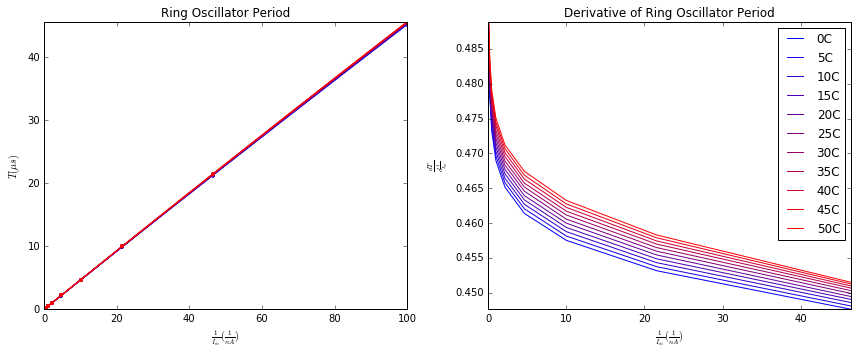

In [19]:
Temps, Iins = readParams(open(folderPath+"SweptParams.csv"))
allTs = []
globalLims = [0,0]
derivLims = [0,100000,0]

for curTemp in Temps:
    fileName = "AH_TempSweep_SizedThin/AH_Inv_FreqMeas_Temp"+str(curTemp)+"C.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, Iins, 
                                        IScaleFactor='nA', TScaleFactor='us',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    print 'Temp: {:>2}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(Iins, curTs,
                                                                       curFitParams, IScaleFactor='nA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

# Calculate the percentage variance that results from the variation in temperature.
TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, Iins, IScaleFactor='nA')
#percVariancebyTemp(TsAsFuncOfIin, Iins, Temps, IScaleFactor='nA')
#mpld3.display()    # Display the plots in interactive mode


## Redo of previous measurements

This is a redo of the measurements made above so that I know I have a working version of the final circuit.  
### Iin 1x, C1 1x, C2 1x

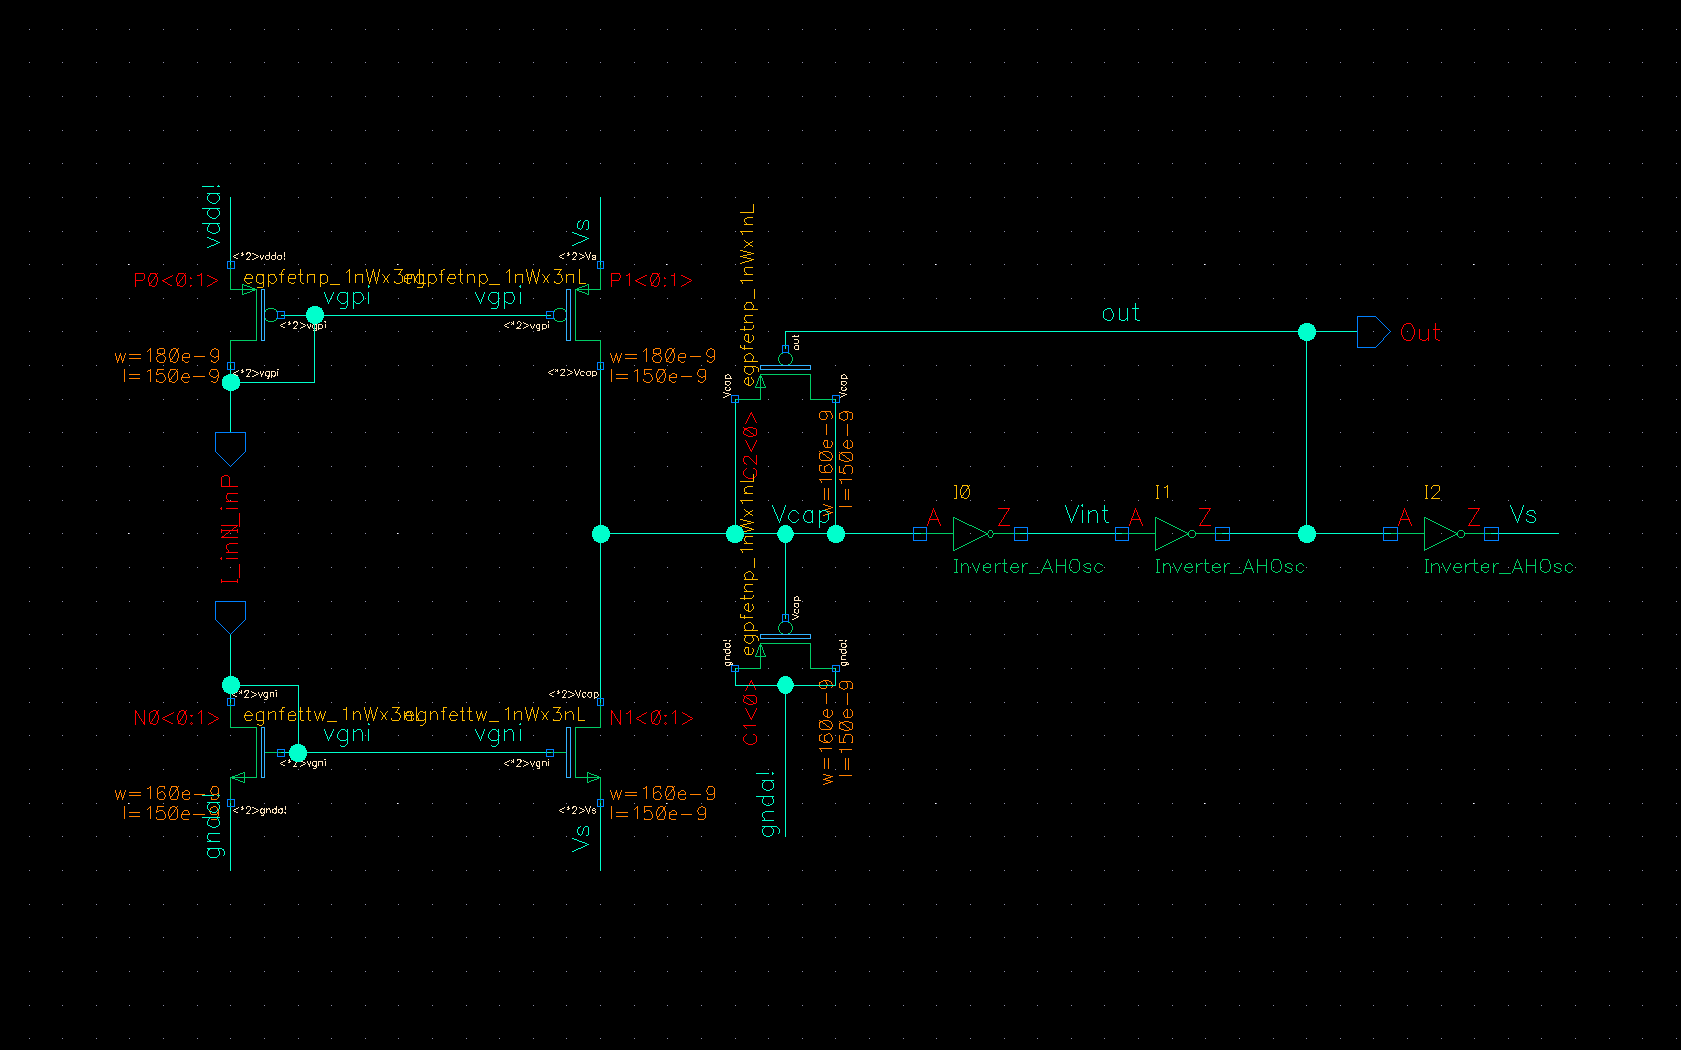

In [119]:
Image(folderPath + "AH_tin/AH_Simp_C1_1x_C2_1x_Iin1x_SwitchonSources.png", width=800)

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-11   3.16227766e-11   1.00000000e-10   3.16227766e-10
   1.00000000e-09   3.16227766e-09   1.00000000e-08]
AH_tin/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin1x_SwitchonSource.csv
AH_tin/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin1x_SwitchonSource.csv
AH_tin/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin1x_SwitchonSource.csv

General Params: [  1.58416834e+15   5.72715518e-13]
Temp: 20-------------
Temp-Specific Params: [  1.58505492e+15   5.75664497e-13]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.010 nA	  -0.746%   	  -0.077%   
 0.032 nA	   1.778%   	   0.163%   
 0.100 nA	   2.173%   	   0.179%   
 0.316 nA	   1.737%   	   0.131%   
 1.000 nA	   0.772%   	   0.054%   
 3.162 nA	  -0.932%   	  -0.061%   
10.000 nA	  -4.196%   	  -0.259%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 nA	   0.795%   	  -0.031%   
 0.032 nA	  -1.778%   	   0.074%   
 0.100 nA	  -2.139%   	   0.094%   
 0.316 nA	  -1.710%   	   0.079%

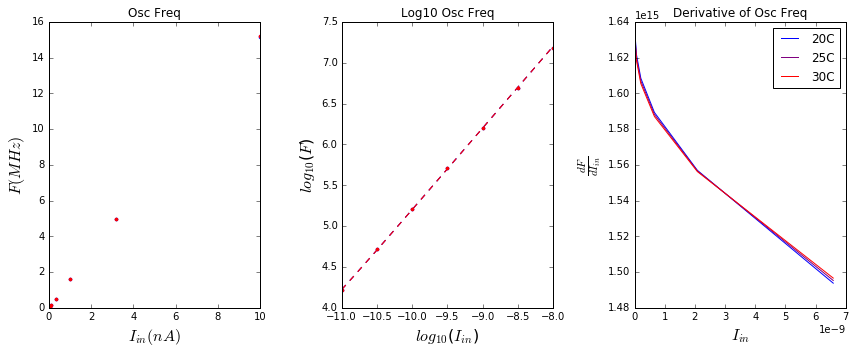

In [68]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_10pAto10nA_7steps.csv", 
      dataFileNamePrefix="AH_tin/AH_Freq_Simp_Temp",
      dataFileNameSuffix="C_C1_1x_C2_1x_Iin1x_SwitchonSource.csv",
      IScaleFactor='nA', FScaleFactor='MHz')

### Iin 2x, C1 1x, C2 1x
#### Sweep from 10pA to 10nA

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-11   3.16227766e-11   1.00000000e-10   3.16227766e-10
   1.00000000e-09   3.16227766e-09   1.00000000e-08]
AH_tin/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin2x_SwitchonSource.csv
AH_tin/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin2x_SwitchonSource.csv
AH_tin/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin2x_SwitchonSource.csv

General Params: [  2.06695864e+15   5.31497944e-13]
Temp: 20-------------
Temp-Specific Params: [  2.06741982e+15   5.37668149e-13]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.010 nA	  -0.774%   	  -0.078%   
 0.032 nA	   1.803%   	   0.161%   
 0.100 nA	   2.222%   	   0.180%   
 0.316 nA	   1.789%   	   0.132%   
 1.000 nA	   0.788%   	   0.054%   
 3.162 nA	  -1.005%   	  -0.064%   
10.000 nA	  -4.413%   	  -0.268%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 nA	   0.821%   	  -0.032%   
 0.032 nA	  -1.801%   	   0.075%   
 0.100 nA	  -2.185%   	   0.096%   
 0.316 nA	  -1.760%   	   0.081%

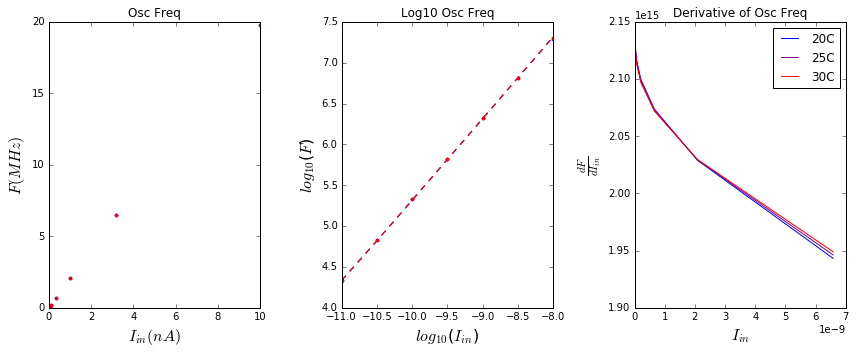

In [69]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_10pAto10nA_7steps.csv", 
      dataFileNamePrefix="AH_tin/AH_Freq_Simp_Temp",
      dataFileNameSuffix="C_C1_1x_C2_1x_Iin2x_SwitchonSource.csv",
      IScaleFactor='nA', FScaleFactor='MHz')

#### Sweep from 1pA to 1nA

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-12   3.16227766e-12   1.00000000e-11   3.16227766e-11
   1.00000000e-10   3.16227766e-10   1.00000000e-09]
AH_tin/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin2x_SwitchonSource_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin2x_SwitchonSource_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin2x_SwitchonSource_1pAto1nA.csv

General Params: [  2.11810168e+15   8.96733914e-14]
Temp: 20-------------
Temp-Specific Params: [  2.11968617e+15   8.75515995e-14]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.001 nA	  -0.566%   	  -0.073%   
 0.003 nA	   0.966%   	   0.109%   
 0.010 nA	   1.071%   	   0.107%   
 0.032 nA	   0.729%   	   0.065%   
 0.100 nA	   0.194%   	   0.016%   
 0.316 nA	  -0.530%   	  -0.040%   
 1.000 nA	  -1.603%   	  -0.111%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.001 nA	   0.621%   	  -0.022%   
 0.003 nA	  -0.983%   	   0.037%   
 0.010 nA	  -1.069%   	   0.042%   
 0.03

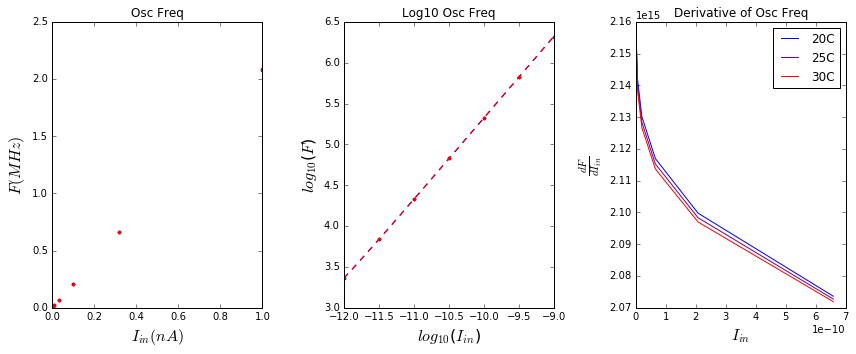

In [70]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_1pAto1nA_7steps.csv", 
       dataFileNamePrefix="AH_tin/AH_Freq_Simp_Temp",
       dataFileNameSuffix="C_C1_1x_C2_1x_Iin2x_SwitchonSource_1pAto1nA.csv",
      IScaleFactor='nA', FScaleFactor='MHz')

This design is the "winner" for the thin-oxide/large current form of the ADC.  We can simulate from 1pA to 10nA with minimal temperature variance and with speeds fast enough to handle the synapse output.  The synapse output will vary from 1pA to 100pA and needs to be sampled at least every 2 ms (>500MHz).  If we set the reference current to 1pA, we can sample every ~450us or at a sampling rate of 2.2kHz.

### Iin 3x, C1 1x, C2 1x

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-11   3.16227766e-11   1.00000000e-10   3.16227766e-10
   1.00000000e-09   3.16227766e-09   1.00000000e-08]
AH_tin/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin3x_SwitchonSource.csv
AH_tin/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin3x_SwitchonSource.csv
AH_tin/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin3x_SwitchonSource.csv

General Params: [  1.72218523e+15   4.64512080e-13]
Temp: 20-------------
Temp-Specific Params: [  1.72100155e+15   4.70207896e-13]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.010 nA	  -0.755%   	  -0.077%   
 0.032 nA	   1.499%   	   0.136%   
 0.100 nA	   1.821%   	   0.150%   
 0.316 nA	   1.392%   	   0.105%   
 1.000 nA	   0.469%   	   0.033%   
 3.162 nA	  -1.031%   	  -0.067%   
10.000 nA	  -3.681%   	  -0.225%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 nA	   0.796%   	  -0.031%   
 0.032 nA	  -1.498%   	   0.062%   
 0.100 nA	  -1.797%   	   0.079%   
 0.316 nA	  -1.375%   	   0.063%

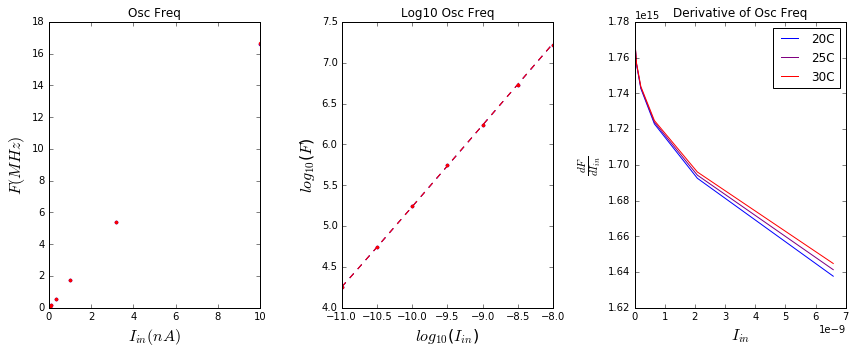

In [71]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_10pAto10nA_7steps.csv", 
       dataFileNamePrefix="AH_tin/AH_Freq_Simp_Temp",
       dataFileNameSuffix="C_C1_1x_C2_1x_Iin3x_SwitchonSource.csv",
      IScaleFactor='nA', FScaleFactor='MHz')

### Iin 2x, C1 1x C2 1x, Switch on Drains
As an experiment, I wanted to see how badly the temperature dependence was affected by adding the switches to the drains.  This would theoretically make the Vcap node look more like a linear slope, which would result in faster measuring speeds for the same amount of current.  If I can get this speed increase without sacrificing the temperature spec by too much, then it might be worth it to do so.

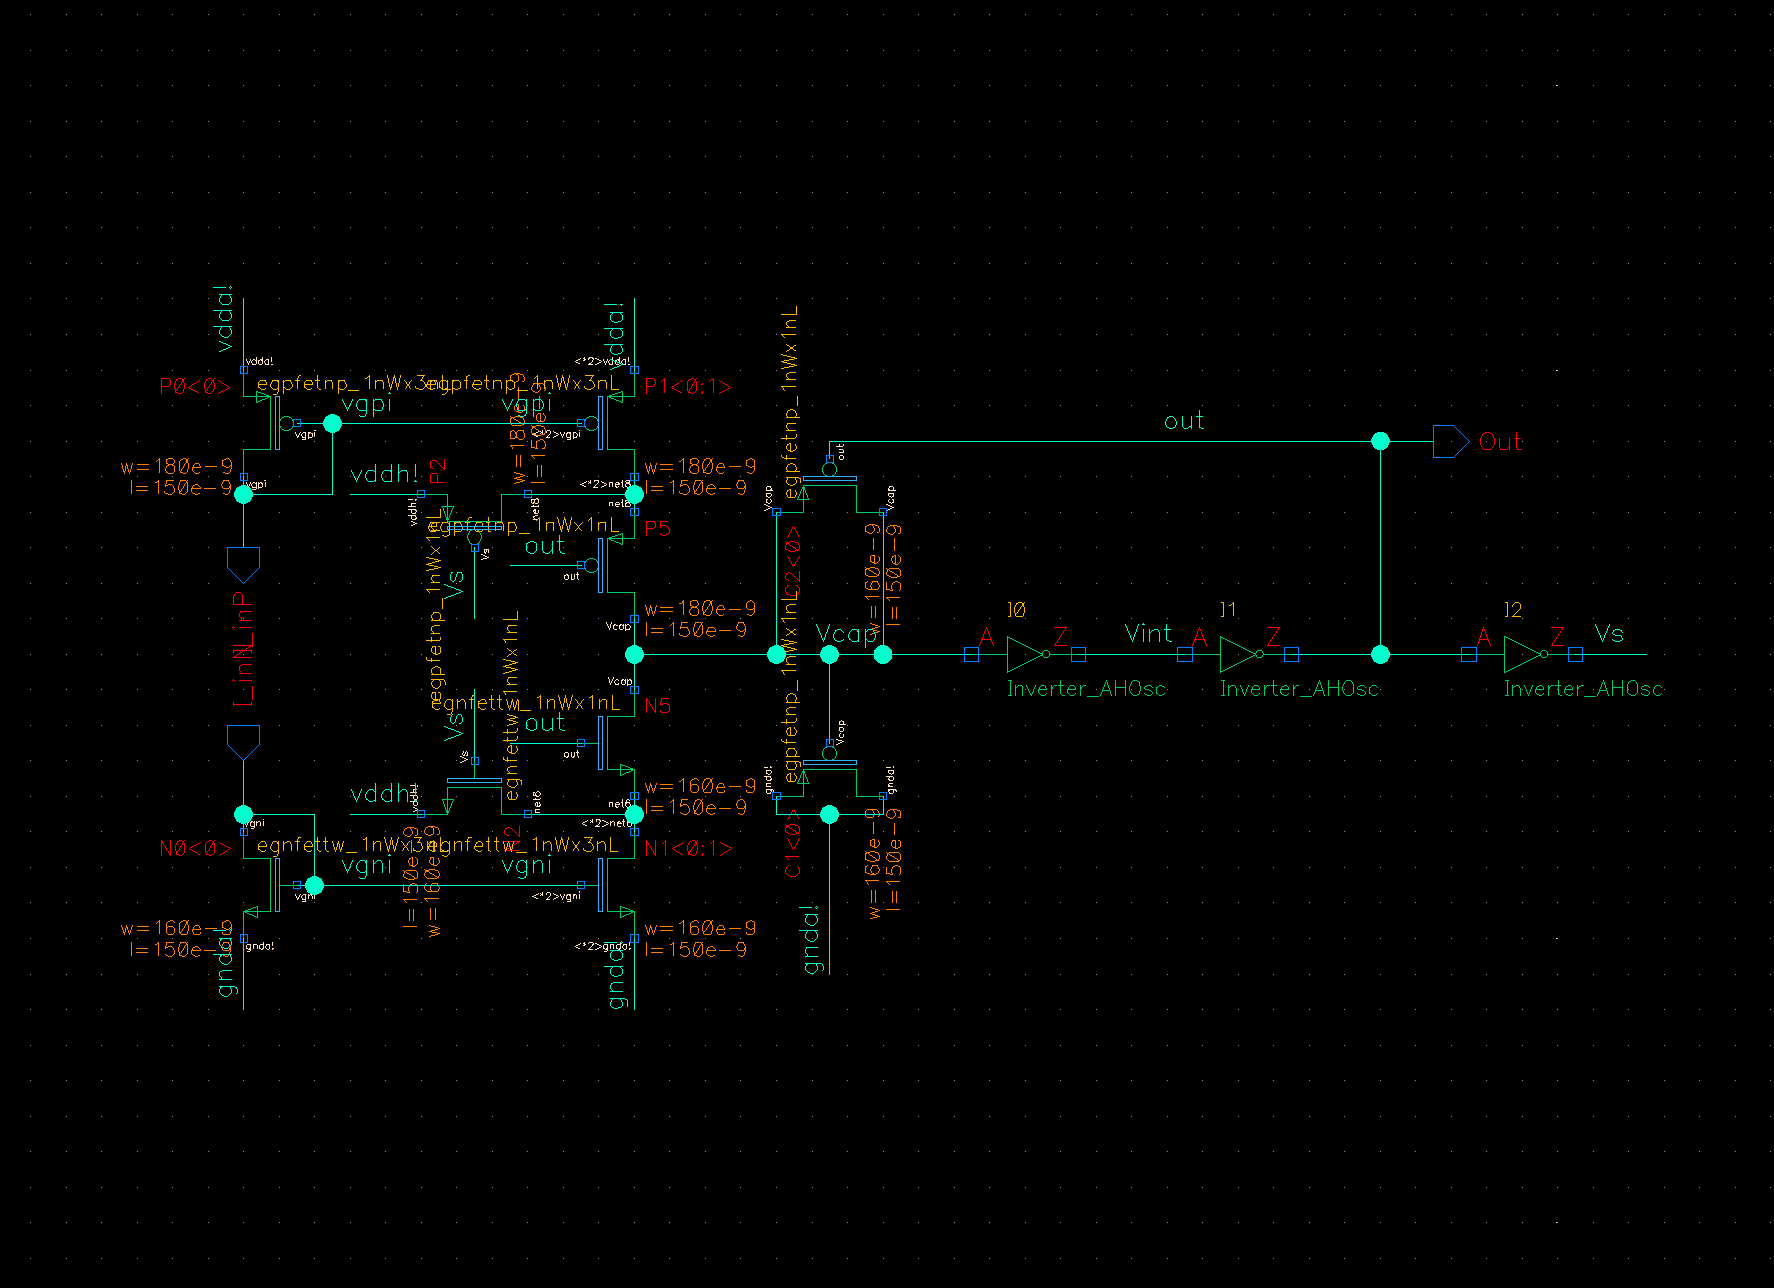

In [198]:
Image(folderPath + "AH_tin/AH_Simp_C1_1x_C2_1x_Iin2x_SwitchonDrains.png", width=800)

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-12   3.16227766e-12   1.00000000e-11   3.16227766e-11
   1.00000000e-10   3.16227766e-10   1.00000000e-09]
AH_tin/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin2x_SwitchonDrain_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin2x_SwitchonDrain_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin2x_SwitchonDrain_1pAto1nA.csv

General Params: [  4.87215449e+15   2.03591046e-13]
Temp: 20-------------
Temp-Specific Params: [  4.82945247e+15   2.04880063e-13]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.001 nA	  -2.981%   	  -0.349%   
 0.003 nA	   3.916%   	   0.396%   
 0.010 nA	   3.784%   	   0.343%   
 0.032 nA	   0.929%   	   0.077%   
 0.100 nA	  -2.069%   	  -0.160%   
 0.316 nA	  -4.065%   	  -0.291%   
 1.000 nA	  -5.079%   	  -0.338%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.001 nA	   3.721%   	  -0.132%   
 0.003 nA	  -4.002%   	   0.154%   
 0.010 nA	  -3.718%   	   0.150%   
 0.032 n

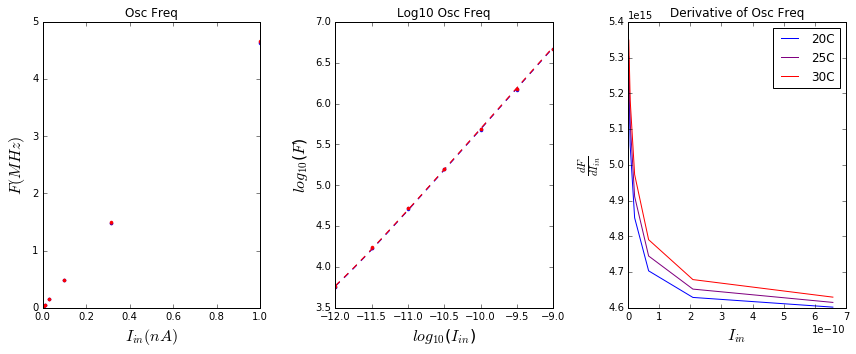

In [72]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_1pAto1nA_7steps.csv", 
       dataFileNamePrefix="AH_tin/AH_Freq_Simp_Temp",
       dataFileNameSuffix="C_C1_1x_C2_1x_Iin2x_SwitchonDrain_1pAto1nA.csv",
      IScaleFactor='nA', FScaleFactor='MHz')

# ThickOxide Inverter for Slow Input Currents
For smaller currents, we found in AHOsc_Char that we can change the inverters, in the feedback chain of inverters, to ThickFET transistors.  The reason we think we can get away with using ThickFETs for smaller currents is because the inverter's gain will still be much faster than the capacitor's charging speed, and as such the non-linearity introduced by the ThickFET will be a much smaller proportion of the switching time of the oscillator.  The sweep will range from 10fA to 10pA (to cover the remaining 2 orders of magnitude).

In this section we compare two biasing circuits (to set the "current source" values).  We are going to investigate Kwabena's Mirror (previously known as the Vcap-based biasing) compared to Ben's Mirror.  We want to analyze these mirrors in more detail to find out which one behaves more ideally over temperature for our input currents.  If we are able to do this, then we will have a better understanding of where our problems are coming from and will therefore be able to make a more informed decision regarding which architecture to use (assuming we can optimize the speeds further).

_Note: To speed up simulation time, I am going to continue to do abridged sweeps of temperatures and $I_{in}$.  Temperature will be swept from $0^{\circ}C-50^{\circ}C$ in 3 equal steps, and input current will have 5 logarithmic steps from 100fA to 10pA._

Our circuit's requirements for small input currents (100fA to 10pA) is to be able to have a maximum period length of 1ms for the smallest input current and a <1% error in period measurements over $50^{\circ}C$.

## Baseline
This baseline is after months of not touching this circuit.  During that time, I tried to figure out a model for the inverter and FDSOI process.  It should be noted that this circuit is slightly different than before because the bias currents are now fed into the circuit using a simple current mirror (to more accurately reflect what would happen within the individual ADC cell.
### Iin 2x, C1 1x, C2 3x

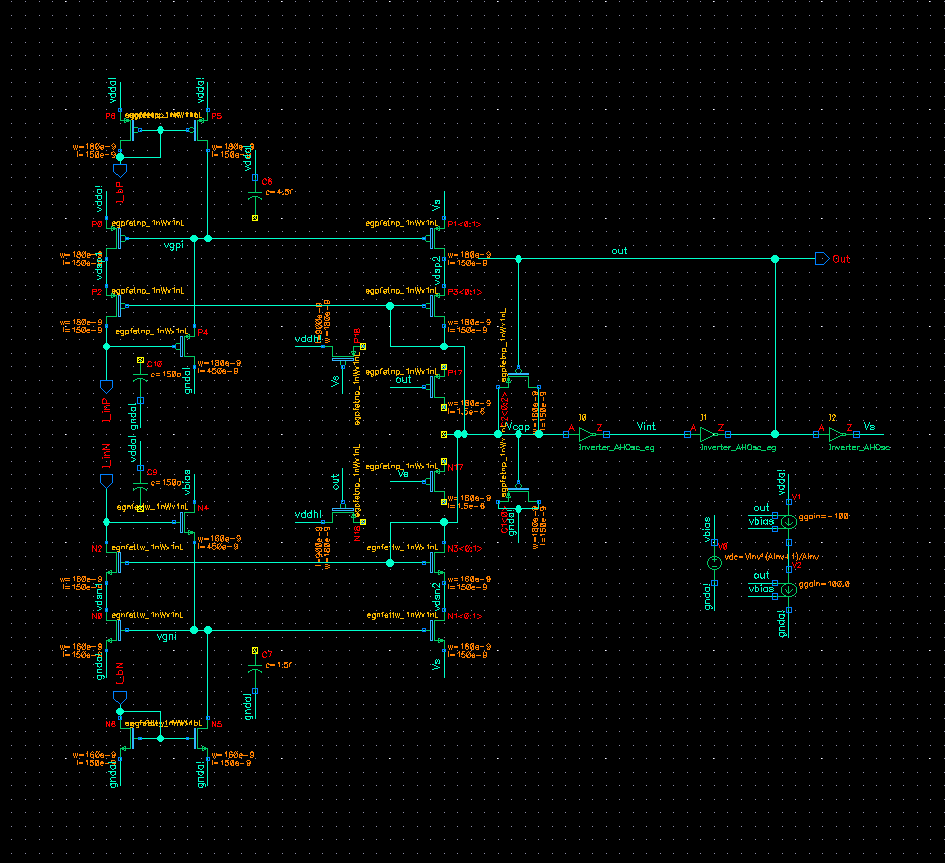

In [97]:
Image(folderPath + "AH_eg/AH_KB_C1_1x_C2_3x_Iin2x.png", width=800)

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_eg/AH_Freq_KB_Temp20C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonSource.csv
AH_eg/AH_Freq_KB_Temp25C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonSource.csv
AH_eg/AH_Freq_KB_Temp30C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonSource.csv

General Params: [  2.65073699e+15   3.06025789e-16]
Temp: 20-------------
Temp-Specific Params: [  2.65035521e+15   2.56032012e-16]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.010 pA	  -0.712%   	  -0.216%   
 0.032 pA	   0.278%   	   0.063%   
 0.100 pA	   0.482%   	   0.086%   
 0.316 pA	   0.406%   	   0.060%   
 1.000 pA	   0.167%   	   0.021%   
 3.162 pA	  -0.331%   	  -0.037%   
10.000 pA	  -1.094%   	  -0.108%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 pA	   0.739%   	  -0.023%   
 0.032 pA	  -0.280%   	   0.009%   
 0.100 pA	  -0.481%   	   0.016%   
 0.316 pA	  -0.405% 

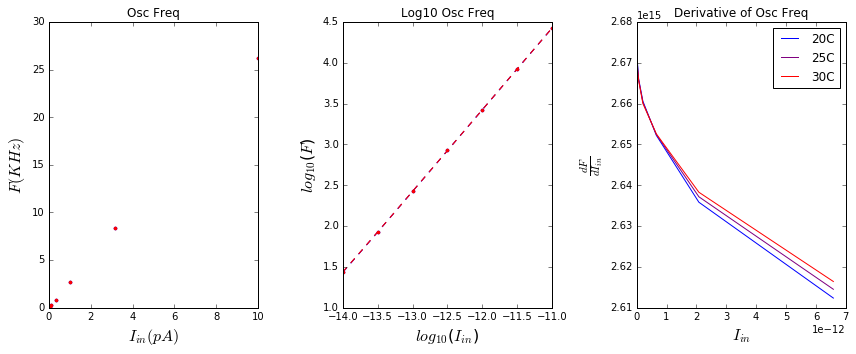

In [257]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_10fAto10pA_7steps.csv", 
      dataFileNamePrefix="AH_eg/AH_Freq_KB_Temp",
      dataFileNameSuffix="C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonSource.csv",
      IScaleFactor='pA', FScaleFactor='KHz')

If we measure the "baseline" using Ben's mirror at 500fA bias current, we see that it performs much worse with respect to temperature variation.  It also behaves slightly slower than the KB mirror version of the baseline.  As such, I will no longer investigate the Ben mirror version.

## Switch only on drains with charge injection minimization
In this next test, we remove the switch on the sources and only have switches on the drains.  To clarify, the sources of the current mirrors are all connected to Vdd and Gnd respectively for PMOS and NMOS.  The circuit is shown below.
### Iin 2x, C1 1x, C2 3x

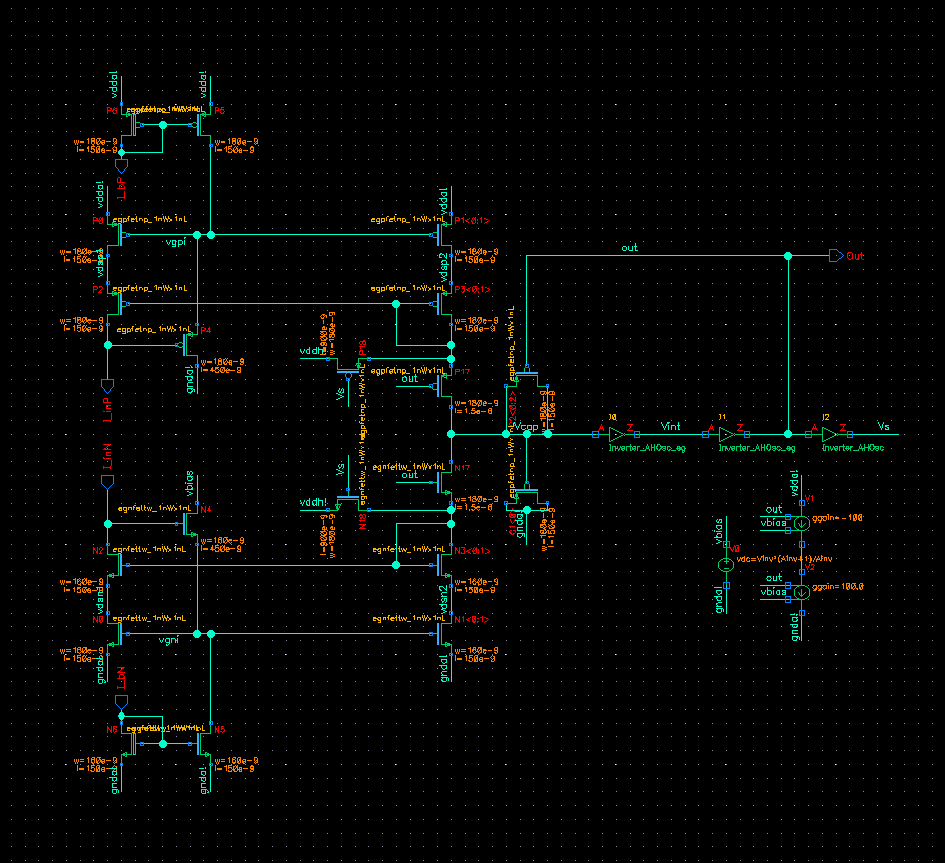

In [96]:
Image(folderPath + "AH_eg/AH_KB_C1_1x_C2_3x_Iin2x_SwitchonDrains.png", width=800)

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_eg/AH_Freq_KB_Temp20C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonDrain.csv
AH_eg/AH_Freq_KB_Temp25C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonDrain.csv
AH_eg/AH_Freq_KB_Temp30C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonDrain.csv

General Params: [  2.04337097e+15   3.10885355e-16]
Temp: 20-------------
Temp-Specific Params: [  2.03994500e+15   2.92984756e-16]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.010 pA	  -0.634%   	  -0.209%   
 0.032 pA	   0.350%   	   0.084%   
 0.100 pA	   0.651%   	   0.122%   
 0.316 pA	   0.574%   	   0.088%   
 1.000 pA	   0.147%   	   0.019%   
 3.162 pA	  -0.673%   	  -0.077%   
10.000 pA	  -1.821%   	  -0.185%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 pA	   0.658%   	  -0.020%   
 0.032 pA	  -0.353%   	   0.011%   
 0.100 pA	  -0.649%   	   0.022%   
 0.316 pA	  -0.572%   	

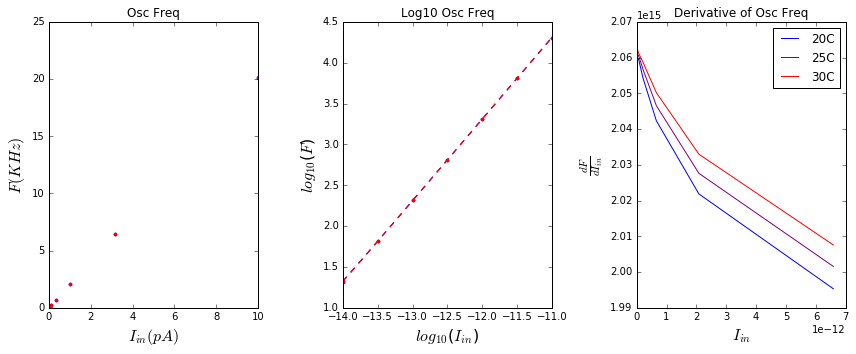

In [253]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_10fAto10pA_7steps.csv", 
      dataFileNamePrefix="AH_eg/AH_Freq_KB_Temp",
      dataFileNameSuffix="C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonDrain.csv",
      IScaleFactor='pA', FScaleFactor='KHz')

### Iin 4x, C1 1x, C2 1x

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_eg/AH_Freq_KB_Temp20C_Ib500p_C1_1x_C2_1x_Iin4x_SwitchonDrain.csv
AH_eg/AH_Freq_KB_Temp25C_Ib500p_C1_1x_C2_1x_Iin4x_SwitchonDrain.csv
AH_eg/AH_Freq_KB_Temp30C_Ib500p_C1_1x_C2_1x_Iin4x_SwitchonDrain.csv

General Params: [  8.04217874e+15   5.35375899e-16]
Temp: 20-------------
Temp-Specific Params: [  8.00836978e+15   5.78119523e-16]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.010 pA	  -1.035%   	  -0.234%   
 0.032 pA	   1.794%   	   0.320%   
 0.100 pA	   2.302%   	   0.340%   
 0.316 pA	   1.715%   	   0.217%   
 1.000 pA	   0.185%   	   0.021%   
 3.162 pA	  -2.169%   	  -0.216%   
10.000 pA	  -4.930%   	  -0.448%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 pA	   1.103%   	  -0.034%   
 0.032 pA	  -1.792%   	   0.058%   
 0.100 pA	  -2.262%   	   0.076%   
 0.316 pA	  -1.689%   	

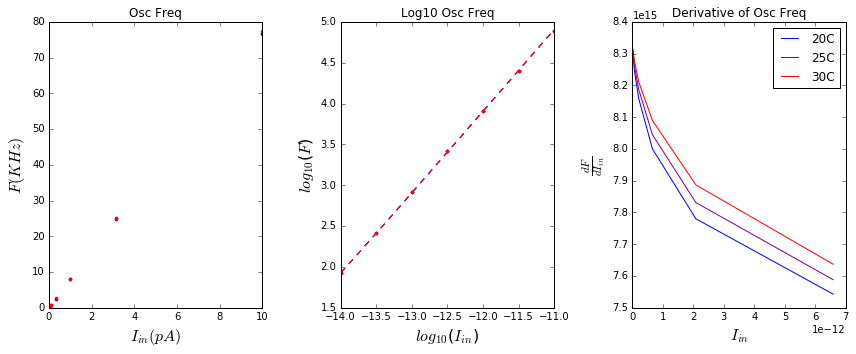

In [75]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_10fAto10pA_7steps.csv", 
      dataFileNamePrefix="AH_eg/AH_Freq_KB_Temp",
      dataFileNameSuffix="C_Ib500p_C1_1x_C2_1x_Iin4x_SwitchonDrain.csv",
      IScaleFactor='pA', FScaleFactor='KHz')

### Iin 10x, C1 1x, C2 3x

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_eg/AH_Freq_KB_Temp20C_Ib500p_C1_1x_C2_3x_Iin10x_SwitchonDrain.csv
AH_eg/AH_Freq_KB_Temp25C_Ib500p_C1_1x_C2_3x_Iin10x_SwitchonDrain.csv
AH_eg/AH_Freq_KB_Temp30C_Ib500p_C1_1x_C2_3x_Iin10x_SwitchonDrain.csv

General Params: [  9.50254260e+15   4.70730856e-16]
Temp: 20-------------
Temp-Specific Params: [  9.47570341e+15   4.70765859e-16]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.010 pA	  -1.156%   	  -0.253%   
 0.032 pA	   1.450%   	   0.252%   
 0.100 pA	   2.226%   	   0.321%   
 0.316 pA	   1.762%   	   0.218%   
 1.000 pA	  -0.125%   	  -0.014%   
 3.162 pA	  -2.072%   	  -0.203%   
10.000 pA	  -3.909%   	  -0.348%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 pA	   1.225%   	  -0.038%   
 0.032 pA	  -1.451%   	   0.047%   
 0.100 pA	  -2.188%   	   0.074%   
 0.316 pA	  -1.734% 

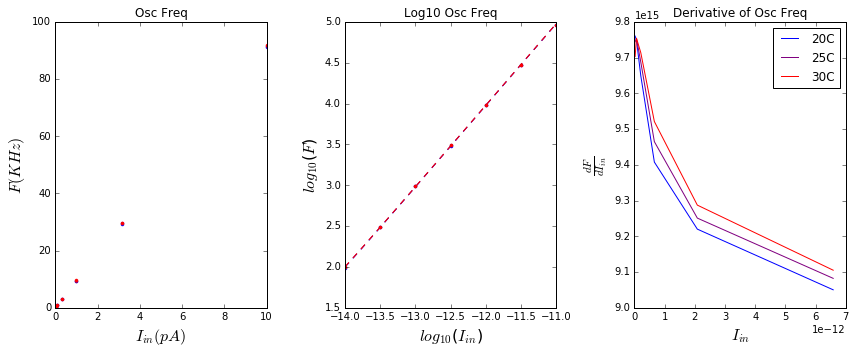

In [76]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_10fAto10pA_7steps.csv", 
      dataFileNamePrefix="AH_eg/AH_Freq_KB_Temp",
      dataFileNameSuffix="C_Ib500p_C1_1x_C2_3x_Iin10x_SwitchonDrain.csv",
      IScaleFactor='pA', FScaleFactor='KHz')

### Iin 100x, C1 1x, C2 3x

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_eg/AH_Freq_KB_Temp20C_Ib500p_C1_1x_C2_3x_Iin100x_SwitchonDrain.csv
AH_eg/AH_Freq_KB_Temp25C_Ib500p_C1_1x_C2_3x_Iin100x_SwitchonDrain.csv
AH_eg/AH_Freq_KB_Temp30C_Ib500p_C1_1x_C2_3x_Iin100x_SwitchonDrain.csv

General Params: [  8.05771838e+16   3.87595585e-15]
Temp: 20-------------
Temp-Specific Params: [  7.93624304e+16   3.81725744e-15]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.010 pA	  -5.485%   	  -0.804%   
 0.032 pA	   6.800%   	   0.827%   
 0.100 pA	   2.513%   	   0.275%   
 0.316 pA	  -2.476%   	  -0.247%   
 1.000 pA	  -2.570%   	  -0.230%   
 3.162 pA	  -0.875%   	  -0.071%   
10.000 pA	  -8.365%   	  -0.642%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 pA	   8.237%   	  -0.245%   
 0.032 pA	  -7.092%   	   0.237%   
 0.100 pA	  -2.544%   	   0.086%   
 0.316 pA	   2.57

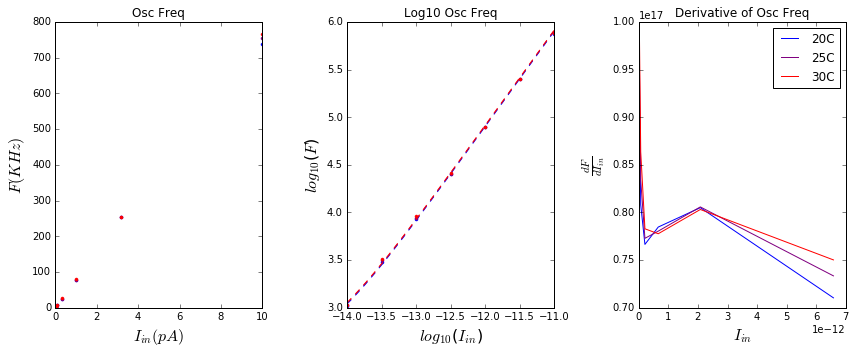

In [77]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_10fAto10pA_7steps.csv", 
      dataFileNamePrefix="AH_eg/AH_Freq_KB_Temp",
      dataFileNameSuffix="C_Ib500p_C1_1x_C2_3x_Iin100x_SwitchonDrain.csv",
      IScaleFactor='pA', FScaleFactor='KHz')

Note: These measurements are still slower than the baseline configuration where we had the switch on the sources

# Monte Carlo Simulations
## ThinFET Iin 2x, C1 1x, C2 1x, 1pA to 1nA
In this section I post my results from performing Monte Carlo simulations on the thin-FET AH circuit.
### Tin No C-element


Iins: [  1.00000000e-12   3.16200000e-12   1.00000000e-11   3.16200000e-11
   1.00000000e-10   3.16200000e-10   1.00000000e-09]
Max Error by Iin: [ 0.00996105  0.0131372   0.01318772  0.00989529  0.00401548  0.00849638
  0.02324089]


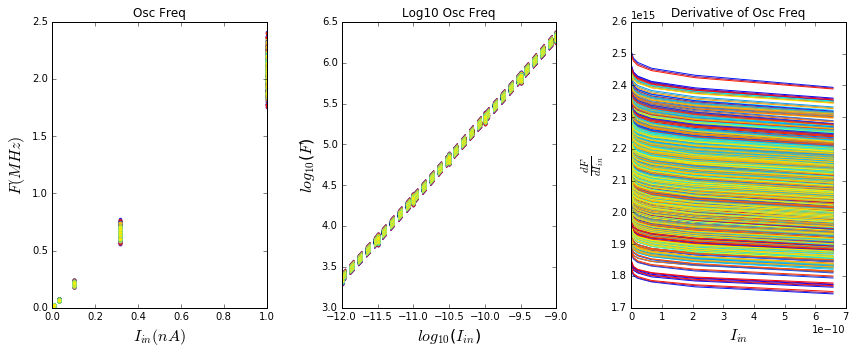

In [247]:
FIFitMC(folderPath+'/MCData/AH_MC_Simp_C1_1x_C2_1x_Iin2x.csv', IScaleFactor='nA', FScaleFactor='MHz')


Iins: [  1.00000000e-12   3.16200000e-12   1.00000000e-11   3.16200000e-11
   1.00000000e-10   3.16200000e-10   1.00000000e-09]
Max Error by Iin: [ 0.00636519  0.01083361  0.01153964  0.00833587  0.00272395  0.00749504
  0.01849924]


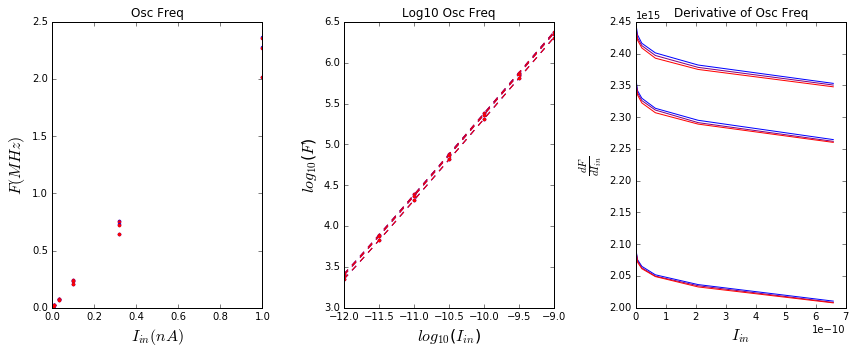

In [246]:
FIFitMC(folderPath+'/MCData/AH_MC_Simp_C1_1x_C2_1x_Iin2x_test.csv', IScaleFactor='nA', FScaleFactor='MHz')

### Tin With C-element

Iins: [  1.00000000e-12   3.16200000e-12   1.00000000e-11   3.16200000e-11
   1.00000000e-10   3.16200000e-10   1.00000000e-09]
Max Error by Iin: [ 0.01377331  0.01780009  0.01754281  0.01343811  0.00652327  0.01224088
  0.03229474]


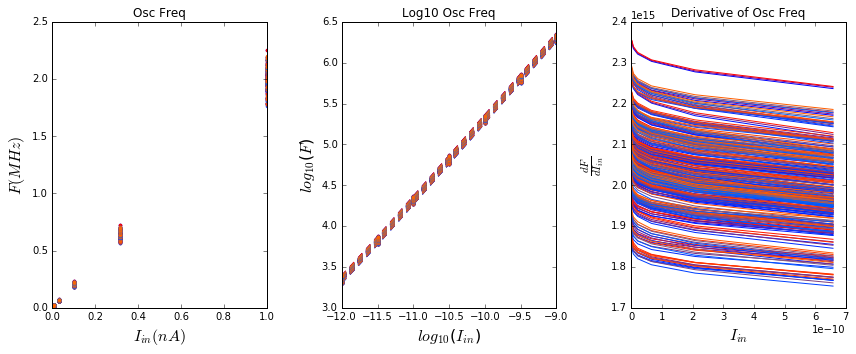

In [273]:
FIFitMC(folderPath+'/MCData/AH_MC_Simp_C1_1x_C2_1x_Iin2x_CEl.csv', IScaleFactor='nA', FScaleFactor='MHz')

## ThickFET Iin 2x, C1 1x, C2 3x, 10fA to 10nA
### EG No C-element

[  3.75654408e+15   2.45790514e-16]
[  3.73354053e+15   2.88867182e-16]
[  3.71147016e+15   3.54103115e-16]
Ckt: 10	Temp: 20
[  3.73354053e+15   2.88867182e-16]
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 pA	   0.010%   	  -0.000%   
 0.032 pA	  -0.896%   	   0.029%   
 0.100 pA	  -1.104%   	   0.037%   
 0.316 pA	  -1.120%   	   0.039%   
 1.000 pA	  -0.860%   	   0.031%   
 3.162 pA	  -0.367%   	   0.014%   
10.000 pA	   0.665%   	  -0.026%   
Ckt: 10	Temp: 25
[  3.73354053e+15   2.88867182e-16]
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 pA	   0.198%   	  -0.006%   
 0.032 pA	  -0.394%   	   0.013%   
 0.100 pA	  -0.498%   	   0.017%   
 0.316 pA	  -0.453%   	   0.016%   
 1.000 pA	  -0.251%   	   0.009%   
 3.162 pA	   0.225%   	  -0.008%   
10.000 pA	   1.183%   	  -0.046%   
Ckt: 10	Temp: 30
[  3.73354053e+15   2.88867182e-16]
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.010 pA	   0.145%   	  -0.

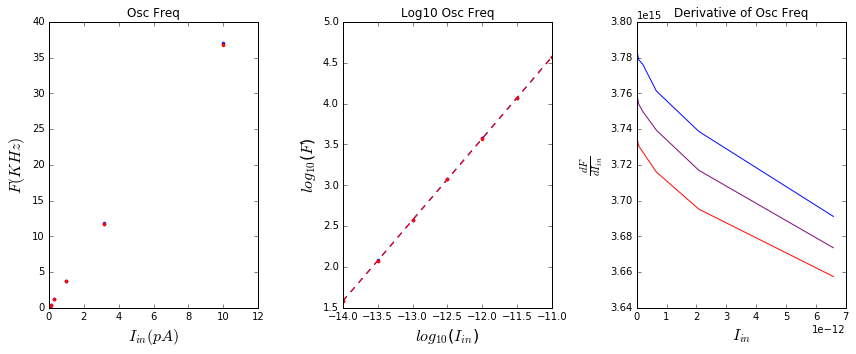

In [306]:
FIFitMC(folderPath+'/MCData/AHeg_MC_Simp_C1_1x_C2_3x_Iin2x.csv',
        IScaleFactor='pA', FScaleFactor='KHz', cktPlotList=[10])

### EG With C-element

In [ ]:
FIFitMC(folderPath+'/MCData/AHeg_MC_Simp_C1_1x_C2_3x_Iin2x_CEl.csv', IScaleFactor='pA', FScaleFactor='KHz')

# Testing w/ C-Element and an Ack/Req signal
Now that we have a couple of designs that seem somewhat promising, we want to add in a method to reset the circuit and also fake an ack/req signals for a 4-phase handshake with the digital logic.  We hope to do this with a simple C-element in place of the 2nd inverter.  As of now, the two "winning" designs are as follows:

    Thin Oxide: Iin 2x, C1 1x, C2 1x, Simple Mirror, Switch on the sources
    Thick Oxide: Iin 4x, C1 1x, C2 1x, KB Mirror, Switch on the drains

## Thin Oxide, Iin 2x, C1 1X, C2 1x, Simple Mirror, Switch on sources

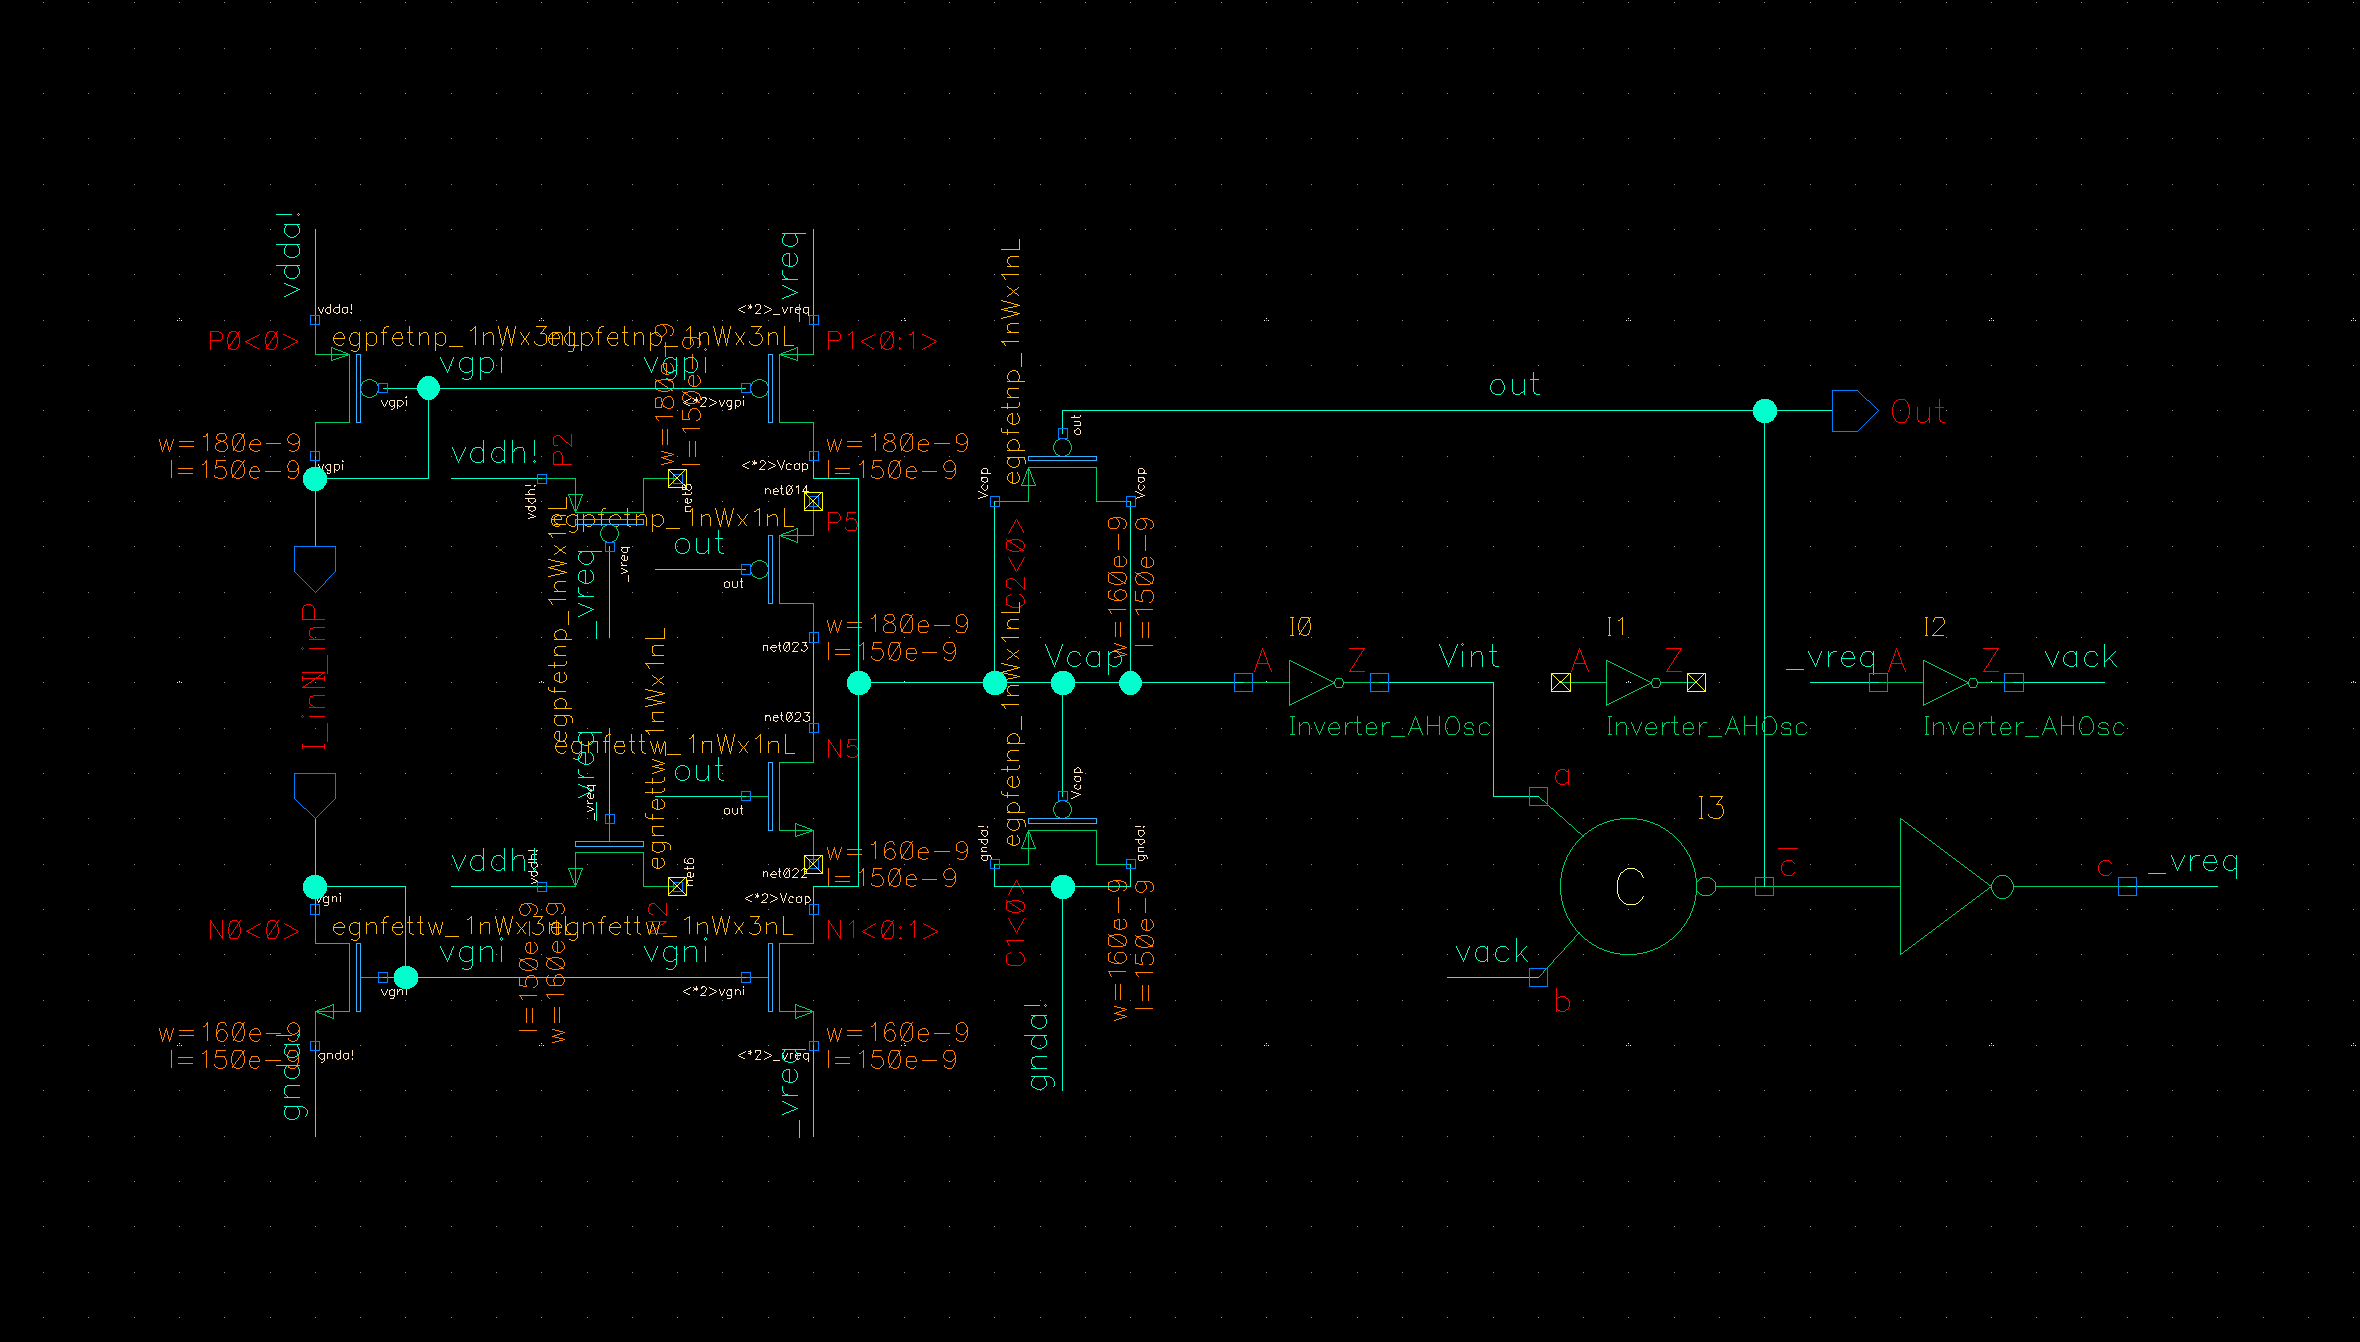

In [230]:
Image(folderPath + "AH_tin/AH_Simp_C1_1x_C2_1x_Iin2x_SwitchonSources_CEl.png", width=800)

### Thick-Oxide C-Element

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-12   3.16227766e-12   1.00000000e-11   3.16227766e-11
   1.00000000e-10   3.16227766e-10   1.00000000e-09]
AH_tin/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin2x_SwitchonSource_CEleg_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin2x_SwitchonSource_CEleg_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin2x_SwitchonSource_CEleg_1pAto1nA.csv

General Params: [  1.81257017e+15   1.01591501e-13]
Temp: 20-------------
Temp-Specific Params: [  1.81041158e+15   9.97425670e-14]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.001 nA	  -0.931%   	  -0.123%   
 0.003 nA	   1.161%   	   0.133%   
 0.010 nA	   1.370%   	   0.139%   
 0.032 nA	   0.979%   	   0.089%   
 0.100 nA	   0.251%   	   0.021%   
 0.316 nA	  -0.911%   	  -0.069%   
 1.000 nA	  -2.932%   	  -0.207%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.001 nA	   1.036%   	  -0.037%   
 0.003 nA	  -1.185%   	   0.045%   
 0.010 nA	  -1.365%   	

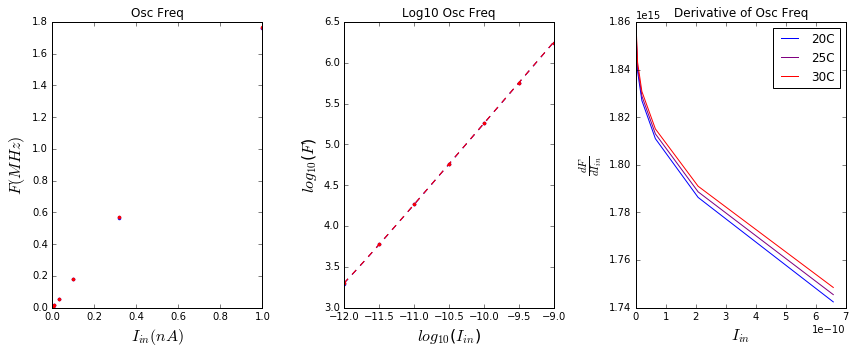

In [78]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_1pAto1nA_7steps.csv", 
      dataFileNamePrefix="AH_tin/AH_Freq_Simp_Temp",
      #dataFileNameSuffix="C_C1_1x_C2_1x_Iin2x_SwitchonSource.csv",
      dataFileNameSuffix="C_C1_1x_C2_1x_Iin2x_SwitchonSource_CEleg_1pAto1nA.csv",
      IScaleFactor='nA', FScaleFactor='MHz')

### Thin-Oxide C-Element

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-12   3.16227766e-12   1.00000000e-11   3.16227766e-11
   1.00000000e-10   3.16227766e-10   1.00000000e-09]
AH_tin/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin2x_SwitchonSource_CEl_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin2x_SwitchonSource_CEl_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin2x_SwitchonSource_CEl_1pAto1nA.csv

General Params: [  2.03761171e+15   9.22198828e-14]
Temp: 20-------------
Temp-Specific Params: [  2.03332328e+15   9.01804495e-14]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.001 nA	  -0.894%   	  -0.117%   
 0.003 nA	   0.784%   	   0.089%   
 0.010 nA	   0.915%   	   0.092%   
 0.032 nA	   0.557%   	   0.050%   
 0.100 nA	  -0.040%   	  -0.003%   
 0.316 nA	  -0.879%   	  -0.066%   
 1.000 nA	  -2.156%   	  -0.150%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.001 nA	   0.986%   	  -0.036%   
 0.003 nA	  -0.800%   	   0.030%   
 0.010 nA	  -0.915%   	   0.0

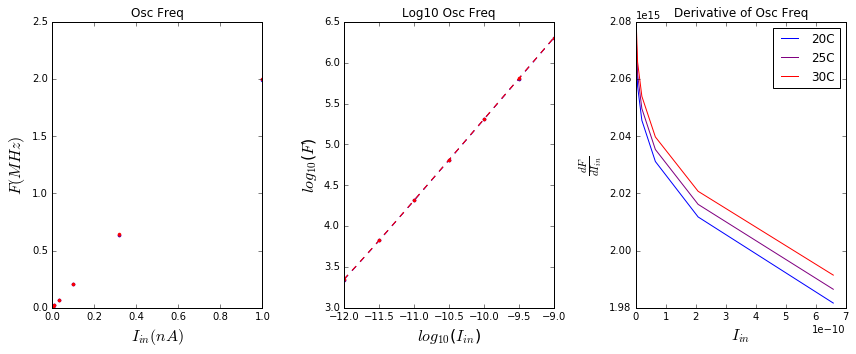

In [79]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_1pAto1nA_7steps.csv", 
      dataFileNamePrefix="AH_tin/AH_Freq_Simp_Temp",
      #dataFileNameSuffix="C_C1_1x_C2_1x_Iin2x_SwitchonSource.csv",
      dataFileNameSuffix="C_C1_1x_C2_1x_Iin2x_SwitchonSource_CEl_1pAto1nA.csv",
      IScaleFactor='nA', FScaleFactor='MHz')

## Thin Oxide, Iin 2x, C1 1X, C2 1x, Simple Mirror, Switch on drains (to get speed up)

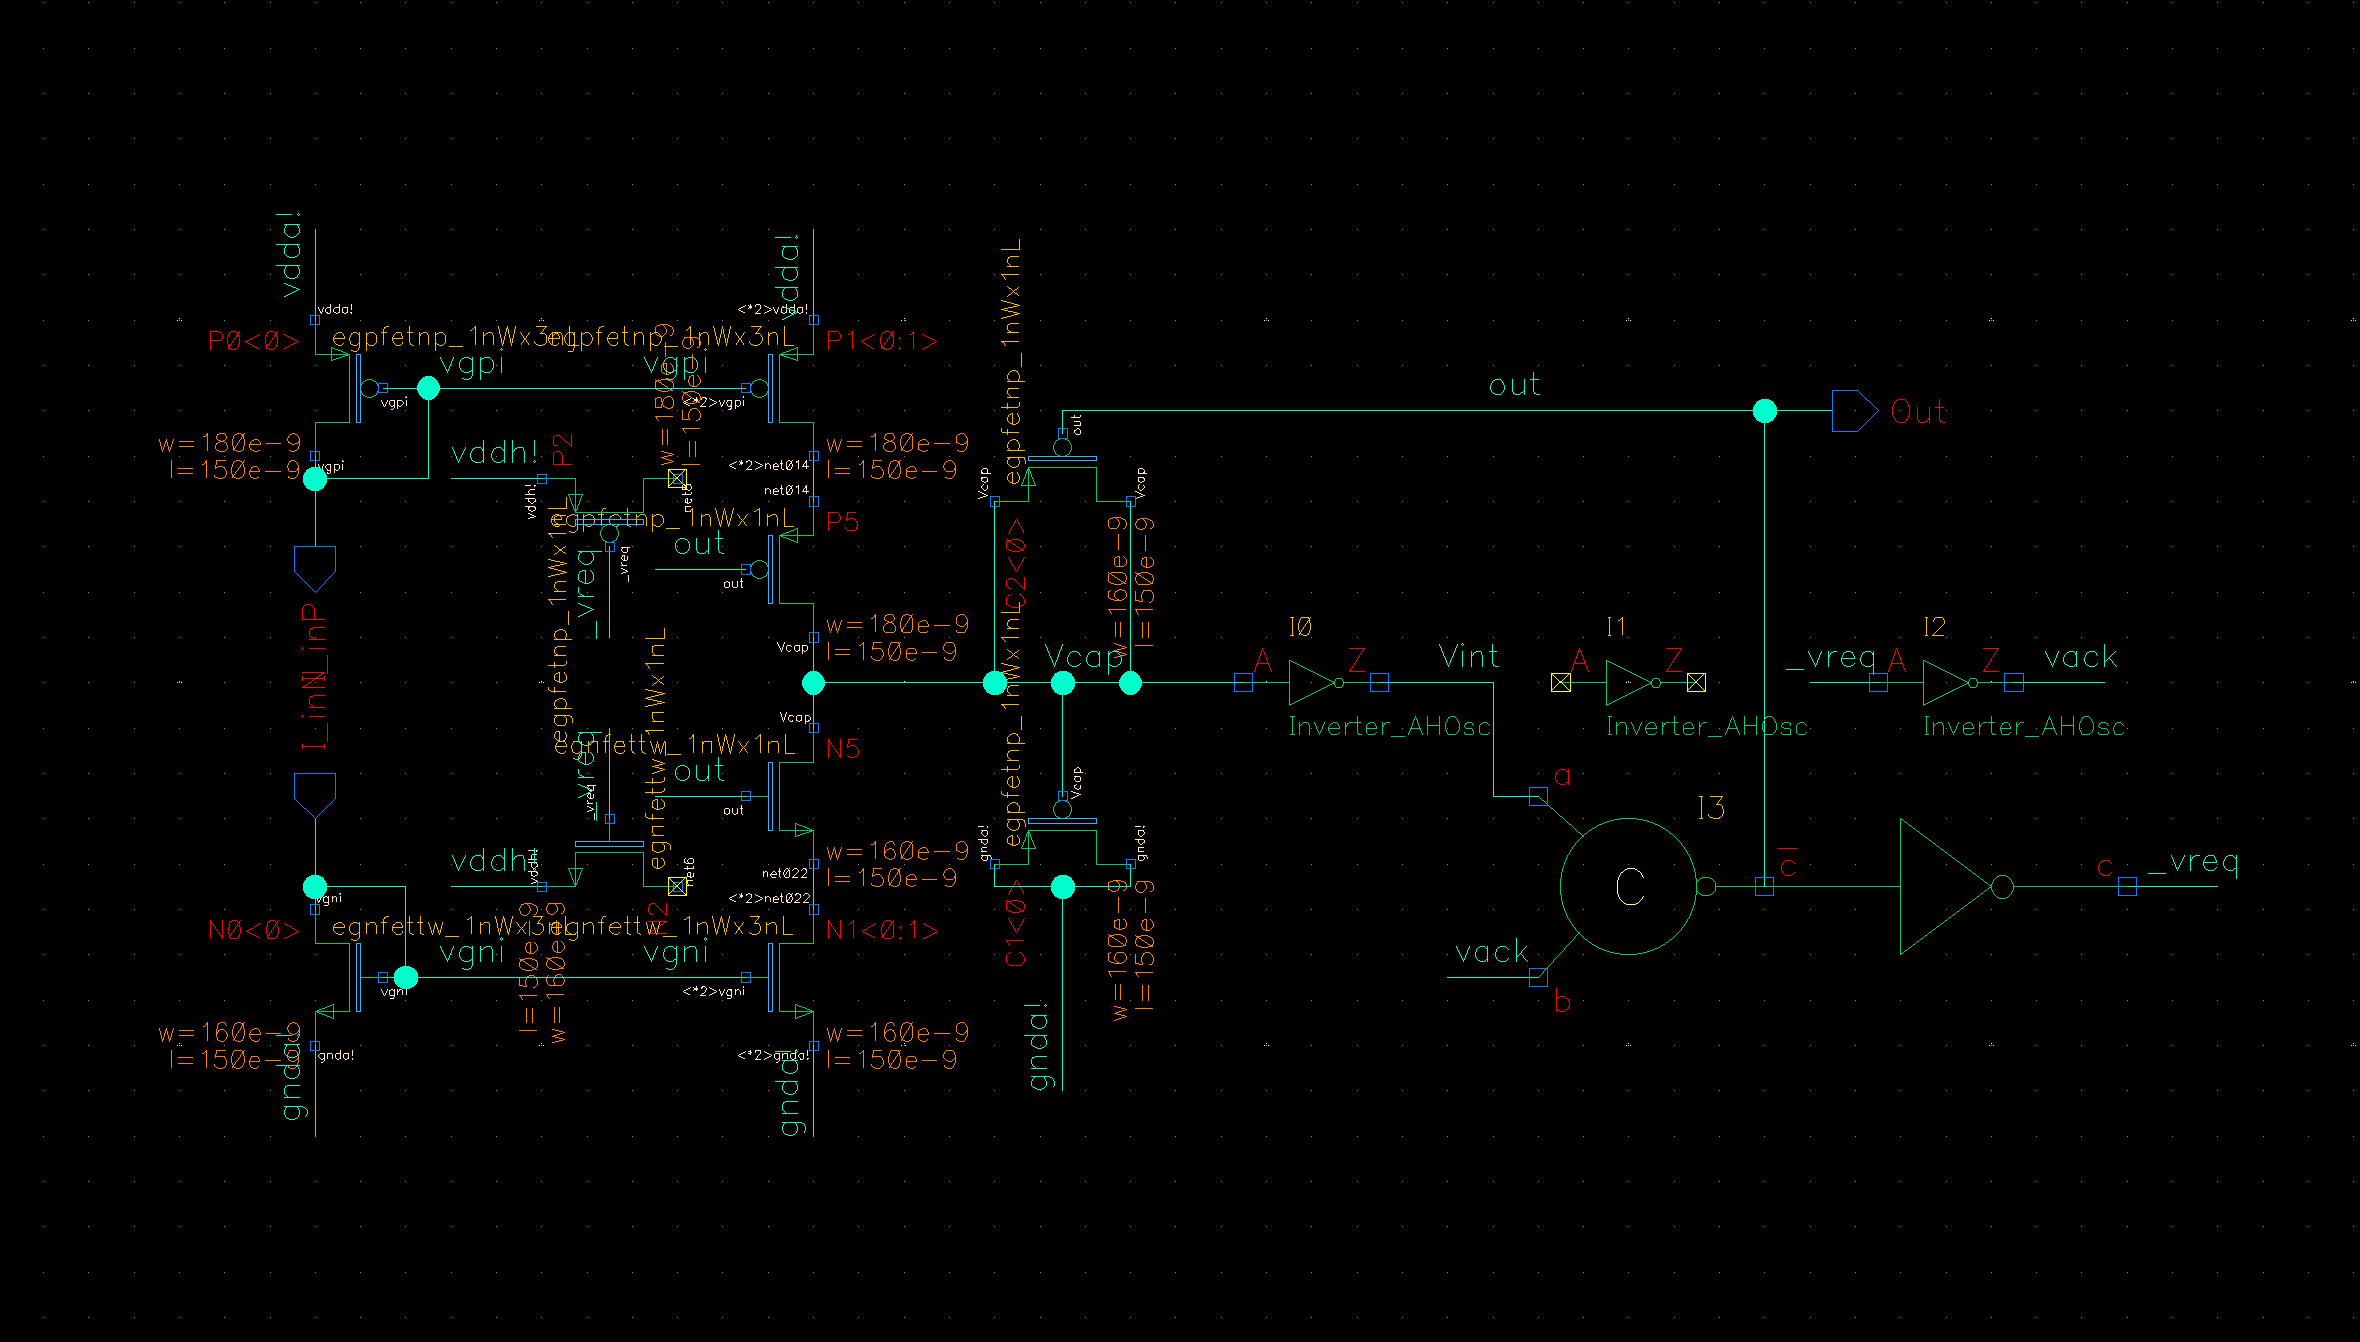

In [210]:
Image(folderPath + "AH_tin/AH_Simp_C1_1x_C2_1x_Iin2x_SwitchonDrains_CEl_NoChargeInjectionMinimization.png", width=800)

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-12   3.16227766e-12   1.00000000e-11   3.16227766e-11
   1.00000000e-10   3.16227766e-10   1.00000000e-09]
AH_tin/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin2x_SwitchonDrain_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin2x_SwitchonDrain_1pAto1nA.csv
AH_tin/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin2x_SwitchonDrain_1pAto1nA.csv

General Params: [  4.87215449e+15   2.03591046e-13]
Temp: 20-------------
Temp-Specific Params: [  4.82945247e+15   2.04880063e-13]
Relative Error in Frequency
 Iins		% Error (lin)	% Error (log)
 0.001 nA	  -2.981%   	  -0.349%   
 0.003 nA	   3.916%   	   0.396%   
 0.010 nA	   3.784%   	   0.343%   
 0.032 nA	   0.929%   	   0.077%   
 0.100 nA	  -2.069%   	  -0.160%   
 0.316 nA	  -4.065%   	  -0.291%   
 1.000 nA	  -5.079%   	  -0.338%   
Relative Error in Input Current
 Iins		% Error (lin)	% Error (log)
 0.001 nA	   3.721%   	  -0.132%   
 0.003 nA	  -4.002%   	   0.154%   
 0.010 nA	  -3.718%   	   0.150%   
 0.032 n

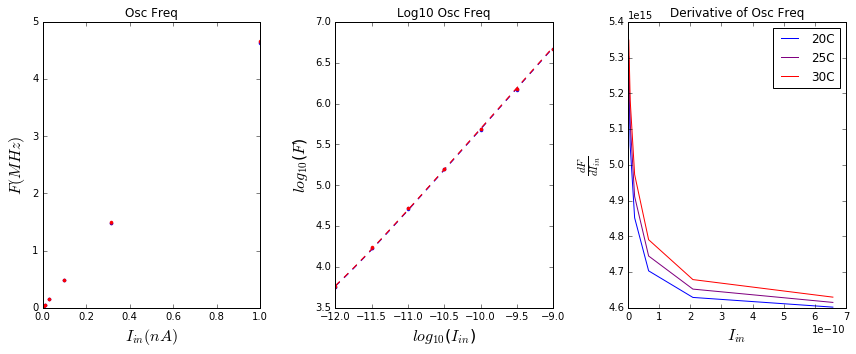

In [82]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_1pAto1nA_7steps.csv", 
      dataFileNamePrefix="AH_tin/AH_Freq_Simp_Temp",
      dataFileNameSuffix="C_C1_1x_C2_1x_Iin2x_SwitchonDrain_1pAto1nA.csv",
      IScaleFactor='nA', FScaleFactor='MHz')

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-12   3.16227766e-12   1.00000000e-11   3.16227766e-11
   1.00000000e-10   3.16227766e-10   1.00000000e-09]
AH_tin/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin2x_SwitchonDrain_CEl_1pAto1nA.csv
[    7874.18051143    24314.42004055    75508.51606419   234152.10764975
   722740.17032601  2212856.41252586  6668346.38287299]
Temp: 20	Relative RMSE: 0.676645%	Params: [  1.31405420e-01   7.17054973e-02  -3.53206475e-05]
AH_tin/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin2x_SwitchonDrain_CEl_1pAto1nA.csv
[    7922.98355823    24467.25747652    76034.64314283   235958.44358149
   728756.10993234  2232493.36725051  6732694.0644819 ]
Temp: 25	Relative RMSE: 0.631946%	Params: [  1.30580874e-01   6.79262703e-02  -3.51715718e-05]
AH_tin/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin2x_SwitchonDrain_CEl_1pAto1nA.csv
[    7971.72802642    24616.23630757    76544.61315398   237724.05891227
   734677.77962834  2251865.57632068  6795981.18130231]
Temp: 30	Relative RMSE: 0.588186%	Params: 

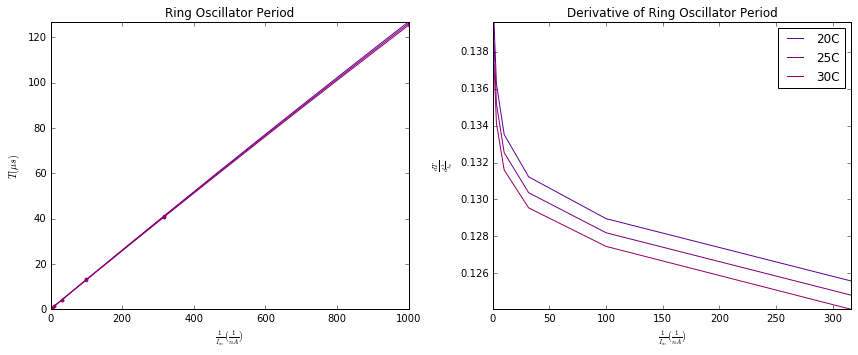

In [211]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_20Cto30C_3Tsteps_1pAto1nA_7steps.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_tin/AH_Freq_Simp_Temp"+str(curTemp)+"C_C1_1x_C2_1x_Iin2x_SwitchonDrain_CEl_1pAto1nA.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='nA', TScaleFactor='us',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='nA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='nA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

## Thick Oxide, Iin 2x, C1 1X, C2 3x, KB Mirror, Switch on Sources

In [ ]:
FIFit(paramFileName="SweptParams_20Cto30C_3Tsteps_10fAto10pA_7steps.csv", 
      dataFileNamePrefix="AH_eg/AH_Freq_KB_Temp",
      dataFileNameSuffix="C_C1_1x_C2_3x_Iin2x_SwitchonSource_CEl.csv",
      IScaleFactor='nA', FScaleFactor='MHz')

# Appendix
In this section are some other tests that I performed along the way

## Pandas Sandbox

In [176]:
MC_df = pd.read_csv(folderPath+'/MCData/AH_MC_Simp_C1_1x_C2_1x_Iin2x_test.csv')
print MC_df.head(5)
print MC_df[MC_df.Iin==1e-12]
freqSeries = MC_df[MC_df.Iin==1e-12].freqVout

print array(freqSeries)
#hist(freqSeries, bins=100)
print freqSeries
print MC_df[0:2]
print MC_df['Point'].value_counts()* max(MC_df['Point'])
print len(MC_df)
print "Howdy"

   Point Corner           Iin    t_stop  temperature  freqVout
0      1   TT_0  1.000000e-12  0.005000           20      2575
1      1   TT_1  1.000000e-12  0.005000           25      2577
2      1   TT_2  1.000000e-12  0.005000           30      2578
3      1   TT_3  3.162000e-12  0.001581           20      7858
4      1   TT_4  3.162000e-12  0.001581           25      7851
    Point Corner           Iin  t_stop  temperature  freqVout
0       1   TT_0  1.000000e-12   0.005           20      2575
1       1   TT_1  1.000000e-12   0.005           25      2577
2       1   TT_2  1.000000e-12   0.005           30      2578
21      2   TT_0  1.000000e-12   0.005           20      2493
22      2   TT_1  1.000000e-12   0.005           25      2494
23      2   TT_2  1.000000e-12   0.005           30      2495
42      3   TT_0  1.000000e-12   0.005           20      2231
43      3   TT_1  1.000000e-12   0.005           25      2234
44      3   TT_2  1.000000e-12   0.005           30      2236
[ 

## Switch on drains and sources, with charge injection minimization
This test shows the same circuit as above, except the switches are connected to, both, the Vcap node and the sources of the current mirror transistors.
### Iin 2x, C1 1x, C2 3x

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_eg/AH_Freq_KB_Temp20C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonDrainandSource.csv
[    20.44882851     64.08900247    201.86419225    635.88391159
   1996.18209422   6208.11350732  19056.64986965]
Temp: 20	Relative RMSE: 0.034334%	Params: [  4.95307423e-01   5.25522938e-03  -1.29562590e-04]
AH_eg/AH_Freq_KB_Temp25C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonDrainandSource.csv
[    20.52876236     64.18789882    201.99081166    636.44155087
   1999.9010751    6230.70090843  19137.07545572]
Temp: 25	Relative RMSE: 0.038418%	Params: [  4.95122454e-01   4.88369778e-03  -1.65292955e-04]
AH_eg/AH_Freq_KB_Temp30C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonDrainandSource.csv
[    20.63423621     64.33607719    202.14651533    636.92151984
   2002.9878464    6250.77075871  19218.98540335]
Temp: 30	Relative RMSE: 0.062798%	Params: [  4.94675178e-01   5.16642431e-03  -2.083

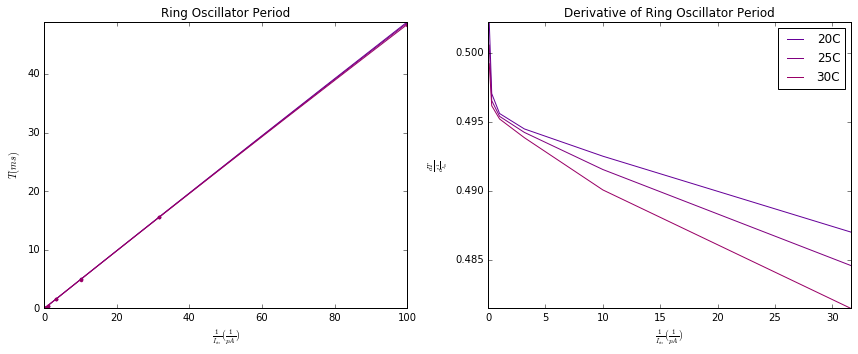

In [194]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

#LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_0Cto50C_3Tsteps_10fAto10pA_4steps.csv"))
#LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_0Cto50C_3Tsteps_10fAto10pA_7steps.csv"))
LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_20Cto30C_3Tsteps_10fAto10pA_7steps.csv"))
for curTemp in sorted(LessTemps):
    #fileName = "AH_eg/AH_Freq_BB_Temp"+str(curTemp)+"C_Ib500f_C1_1x_C2_3x_Iin2x.csv"
    fileName = "AH_eg/AH_Freq_KB_Temp"+str(curTemp)+"C_Ib500p_C1_1x_C2_3x_Iin2x_SwitchonDrainandSource.csv"
    
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

Note: When we switch on both the source and drain, we see decent performance over the 10C variance (20-30C), but the circuit operates slower than it used to with switching only done on the sources.

Various other permutations were tried, like Iin 10x, C1 1x, C2 3x, and Iin 4x, C1 1x, C2 1x, but these resulted in some very odd looking waveforms.  As such, switching on both drain and source simultaneously is being dropped to just switching on the drain or switching on the source.  There is a slight preference to switch on the drain, because it mitigates the amount of capacitance on the Vcap node.

## Switch on drains with simple current mirror
It is hypothesized that the  negative feedback might be causing the current sources to switch more slowly and as such, we can't multiply the input current enough to speed up the circuit.  As such, we wanted to get a psuedo-baseline for a simplified current mirror using a generic current mirror.  The schematic below shows how this circuit is configured

### Iin 2x, C1 1x, C2 3x

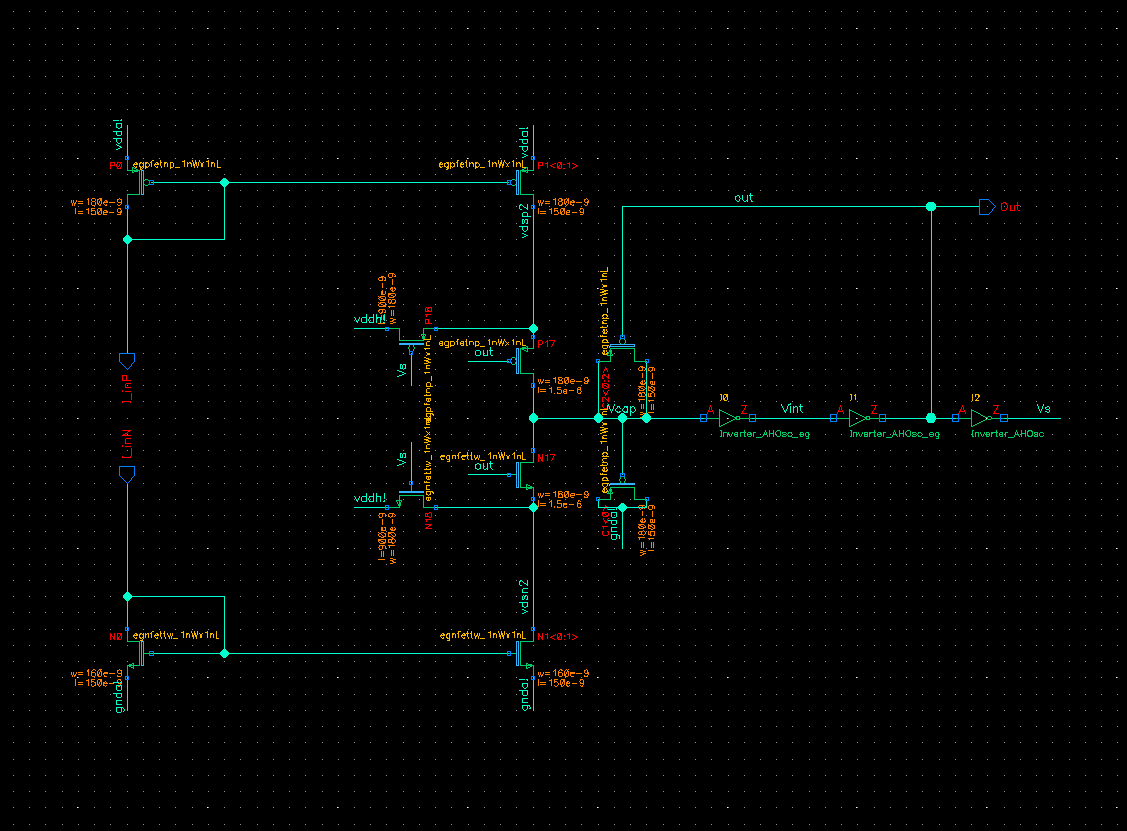

In [94]:
Image(folderPath + "AH_eg/AH_Simp_C1_1x_C2_3x_Iin2x_SwitchonDrains.png", width=800)

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_eg/AH_Freq_Simp_Temp20C_C1_1x_C2_3x_Iin2x_SwitchonDrain.csv
Temp: 20	Relative RMSE: 0.464545%	Params: [ 0.40870992  0.02539812 -0.00110005]
AH_eg/AH_Freq_Simp_Temp25C_C1_1x_C2_3x_Iin2x_SwitchonDrain.csv
Temp: 25	Relative RMSE: 0.396140%	Params: [ 0.40843883  0.02249031 -0.0014851 ]
AH_eg/AH_Freq_Simp_Temp30C_C1_1x_C2_3x_Iin2x_SwitchonDrain.csv
Temp: 30	Relative RMSE: 0.307797%	Params: [ 0.40886435  0.01888149 -0.00208546]

 Iins		Percent Error
 0.010 pA	   8.458%   
 0.032 pA	   2.931%   
 0.100 pA	   1.398%   
 0.316 pA	   1.100%   
 1.000 pA	   1.190%   
 3.162 pA	   1.365%   
10.000 pA	   1.422%   


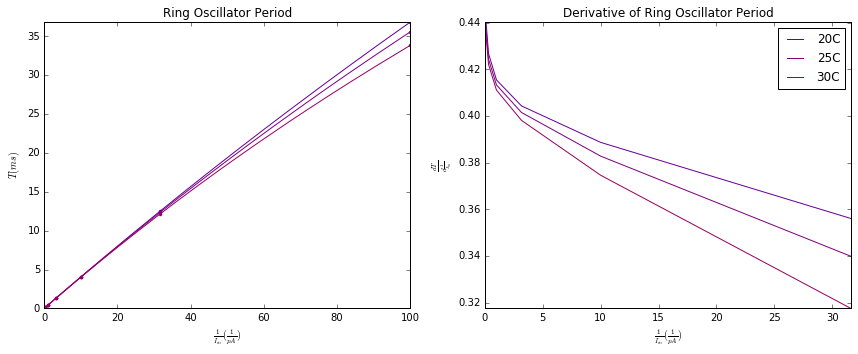

In [98]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_20Cto30C_3Tsteps_10fAto10pA_7steps.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_eg/AH_Freq_Simp_Temp"+str(curTemp)+"C_C1_1x_C2_3x_Iin2x_SwitchonDrain.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

We are now back to the same initial speed that we had with a complex mirror and the switch on the source.  With that said, this circuit doesn't behave as linearly as with a nice mirror and it is also extremely sensitive to temperature over the 10C span that we currently care about.

### Iin 6x, C1 1x, C2 3x
Because we assume that we can now multiply currents more easily, we want to test how the circuit behaves if we multiply more current into the circuit.

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_eg/AH_Freq_Simp_Temp20C_C1_1x_C2_3x_Iin6x_SwitchonDrain.csv
Temp: 20	Relative RMSE: 0.706775%	Params: [ 0.11913517  0.02065114 -0.00160438]
AH_eg/AH_Freq_Simp_Temp25C_C1_1x_C2_3x_Iin6x_SwitchonDrain.csv
Temp: 25	Relative RMSE: 0.626662%	Params: [ 0.11822771  0.01874886 -0.00197464]
AH_eg/AH_Freq_Simp_Temp30C_C1_1x_C2_3x_Iin6x_SwitchonDrain.csv
Temp: 30	Relative RMSE: 0.546570%	Params: [ 0.11759851  0.01675031 -0.0025557 ]

 Iins		Percent Error
 0.010 pA	   9.176%   
 0.032 pA	   4.134%   
 0.100 pA	   3.034%   
 0.316 pA	   3.298%   
 1.000 pA	   3.545%   
 3.162 pA	   3.156%   
10.000 pA	   2.568%   


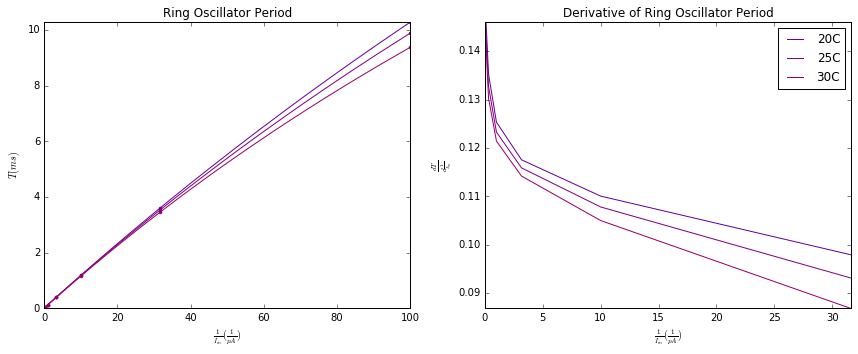

In [99]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_20Cto30C_3Tsteps_10fAto10pA_7steps.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_eg/AH_Freq_Simp_Temp"+str(curTemp)+"C_C1_1x_C2_3x_Iin6x_SwitchonDrain.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

### Iin 20x, C1 1x, C2 2x
I noticed two things.  First of all, I noticed that the period does decrease by almost the exact multiple by which I multiplied the input current.  As such, I want to try and use this to my advantage by making Iin 20x, instead of just 6x.  The other thing that I saw was that the jump distance, $\Delta V$, was jumping up to almost .9 volts.  As such, I can decrease the size of C2 to make the jump distance smaller.  This is why C2 is now 2x instead of the previous 3x.

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_eg/AH_Freq_Simp_Temp20C_C1_1x_C2_2x_Iin20x_SwitchonDrain.csv
Temp: 20	Relative RMSE: 0.611710%	Params: [ 0.02743172  0.00751247 -0.00275612]
AH_eg/AH_Freq_Simp_Temp25C_C1_1x_C2_2x_Iin20x_SwitchonDrain.csv
Temp: 25	Relative RMSE: 0.557052%	Params: [ 0.02704477  0.00699858 -0.00311965]
AH_eg/AH_Freq_Simp_Temp30C_C1_1x_C2_2x_Iin20x_SwitchonDrain.csv
Temp: 30	Relative RMSE: 0.501603%	Params: [ 0.02675224  0.00642099 -0.00370043]

 Iins		Percent Error
 0.010 pA	   9.648%   
 0.032 pA	   5.202%   
 0.100 pA	   4.474%   
 0.316 pA	   4.665%   
 1.000 pA	   4.065%   
 3.162 pA	   3.133%   
10.000 pA	   2.693%   


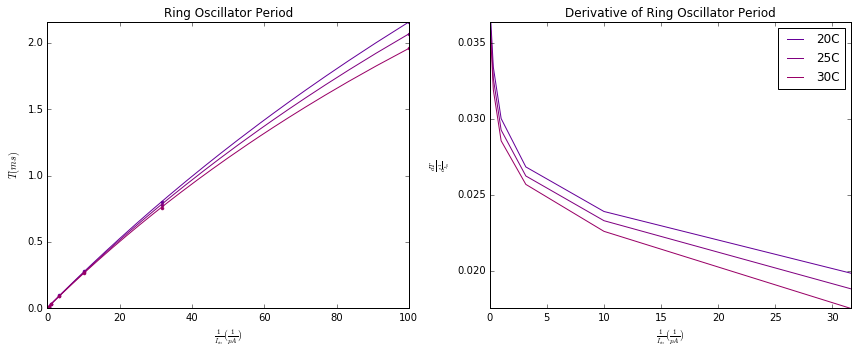

In [108]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_20Cto30C_3Tsteps_10fAto10pA_7steps.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_eg/AH_Freq_Simp_Temp"+str(curTemp)+"C_C1_1x_C2_2x_Iin20x_SwitchonDrain.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode

### Iin 20x, C1 1x, C2 1x
The jump distance is still very large. As such, I am decreasing the size of C2 to make the jump distance even smaller, down to 1x.

Temps:  [20, 25, 30]
Iins:  [  1.00000000e-14   3.16227766e-14   1.00000000e-13   3.16227766e-13
   1.00000000e-12   3.16227766e-12   1.00000000e-11]
AH_eg/AH_Freq_Simp_Temp20C_C1_1x_C2_1x_Iin20x_SwitchonDrain.csv
Temp: 20	Relative RMSE: 0.506335%	Params: [ 0.01932423  0.00530842 -0.00275236]
AH_eg/AH_Freq_Simp_Temp25C_C1_1x_C2_1x_Iin20x_SwitchonDrain.csv
Temp: 25	Relative RMSE: 0.453198%	Params: [ 0.01907449  0.00488863 -0.00314096]
AH_eg/AH_Freq_Simp_Temp30C_C1_1x_C2_1x_Iin20x_SwitchonDrain.csv
Temp: 30	Relative RMSE: 0.397081%	Params: [ 0.01889865  0.00441645 -0.0037642 ]

 Iins		Percent Error
 0.010 pA	   9.868%   
 0.032 pA	   5.111%   
 0.100 pA	   4.459%   
 0.316 pA	   4.803%   
 1.000 pA	   4.197%   
 3.162 pA	   3.175%   
10.000 pA	   2.993%   


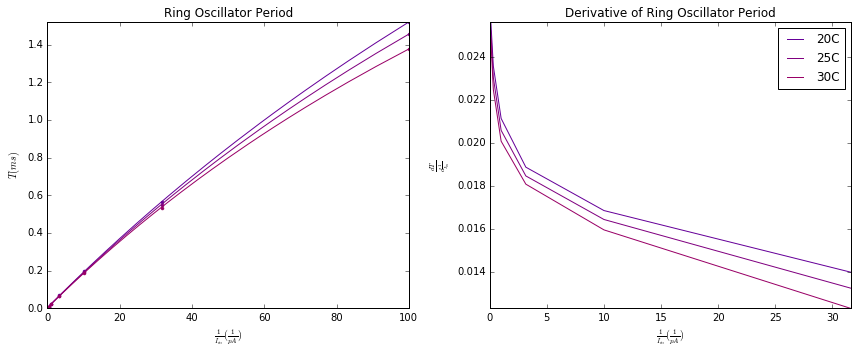

In [109]:
allTs = []
allParams = []
globalLims = [0,0]
derivLims = [0,100000,0]

LessTemps, SmallIins = readParams(open(folderPath+"SweptParams_20Cto30C_3Tsteps_10fAto10pA_7steps.csv"))
for curTemp in sorted(LessTemps):
    fileName = "AH_eg/AH_Freq_Simp_Temp"+str(curTemp)+"C_C1_1x_C2_1x_Iin20x_SwitchonDrain.csv"
    print fileName
    curTs, curFitParams, globalLims, derivLims = plotLinearity(folderPath+fileName, SmallIins, 
                                        IScaleFactor='pA', TScaleFactor='ms',
                                        Lims=globalLims, dLims=derivLims)
    allTs.append(curTs)
    allParams.append(curFitParams)
    print 'Temp: {}\tRelative RMSE: {:%}\tParams: {}'.format(curTemp,
                                                             calcRRMSE(SmallIins, curTs,
                                                                       curFitParams, IScaleFactor='pA'),
                                                             curFitParams)
legend(loc='best')
tight_layout()

TsAsFuncOfIin = array(allTs).T
#print TsAsFuncOfIin
percVariancebyTemp(TsAsFuncOfIin, SmallIins, IScaleFactor='pA')
#percVariancebyTemp(TsAsFuncOfIin, SmallIins, LessTemps, IScaleFactor='pA')
#mpld3.display()    # Display the plots in interactive mode